### 2D and 3D phase space reconstructions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import multiprocessing
import os
import zipfile
from minepy import MINE

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_2d_dir = os.path.join(base_dir, '2dembedding_data')
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')
plots_directory = os.path.join(base_dir, 'plots')

# Ensure directories exist
for dir_path in [embedding_2d_dir, embedding_3d_dir, plots_directory]:
    os.makedirs(dir_path, exist_ok=True)

# Load EEG data
EEG_data = np.load(os.path.join(base_dir, 'eeg_data_with_channels.npy'), allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

sampling_rate = 1000  # Hz
start_time, end_time = 805.571, 921.515 # Data without stimulation occuring
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
filtered_EEG_data = EEG_data[start_index:end_index, :]

max_dim = 20

def mutual_info_worker(args):
    data1, data2 = args
    mine = MINE(alpha=0.6, c=15)
    mine.compute_score(data1, data2)
    return mine.mic()

def determine_delay(data, max_delay=100, subsample_factor=10):
    subsampled_data = data[::subsample_factor]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        mi_values = pool.map(mutual_info_worker, [(subsampled_data[:-i], subsampled_data[i:]) for i in range(1, max_delay + 1)])
    return np.argmin(mi_values) + 1

def delay_embedding(data, emb_dim, delay):
    N = len(data)
    return np.array([data[i:i + emb_dim * delay:delay] for i in range(N - (emb_dim - 1) * delay)])

def false_nearest_neighbors(data, emb_dim, delay, R=10):
    N = len(data)
    false_neighbors = np.zeros(emb_dim)
    for d in range(1, emb_dim + 1):
        emb_data = delay_embedding(data, d, delay)
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_data)
        distances, indices = nbrs.kneighbors(emb_data)
        false_neighbors[d - 1] = np.mean((np.abs(distances[:, 0] - distances[:, 1]) / distances[:, 1]) > R)
    return false_neighbors

# Analyze each EEG channel
for channel_name in eeg_channel_names:
    channel_index = eeg_channel_names.index(channel_name)
    channel_data = filtered_EEG_data[:, channel_index]

    optimal_delay = determine_delay(channel_data, max_delay=20, subsample_factor=10)
    emb_dim_2d, emb_dim_3d = 2, 3

    embedded_data_2d = delay_embedding(channel_data, emb_dim_2d, optimal_delay)
    embedded_data_3d = delay_embedding(channel_data, emb_dim_3d, optimal_delay)

    np.save(os.path.join(embedding_2d_dir, f'2dembedded_{channel_name}.npy'), embedded_data_2d)
    np.save(os.path.join(embedding_3d_dir, f'3dembedded_{channel_name}.npy'), embedded_data_3d)

    # Generate and save plots
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data_2d[:, 0], embedded_data_2d[:, 1], s=1)
    plt.title(f'2D Phase Space Reconstruction for {channel_name}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.savefig(os.path.join(plots_directory, f'2D_{channel_name}.png'))
    plt.close()

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embedded_data_3d[:, 0], embedded_data_3d[:, 1], embedded_data_3d[:, 2], s=1)
    ax.set_title(f'3D Phase Space Reconstruction for {channel_name}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.savefig(os.path.join(plots_directory, f'3D_{channel_name}.png'))
    plt.close()

# Zip the embedded data directories
for dir_path, zip_name in [(embedding_2d_dir, '2d_embedded_data.zip'), (embedding_3d_dir, '3d_embedded_data.zip')]:
    with zipfile.ZipFile(os.path.join(base_dir, zip_name), 'w') as zipf:
        for file in os.listdir(dir_path):
            zipf.write(os.path.join(dir_path, file), file)

print("All processes completed successfully.")

### Elbows for getting an idea for parameters

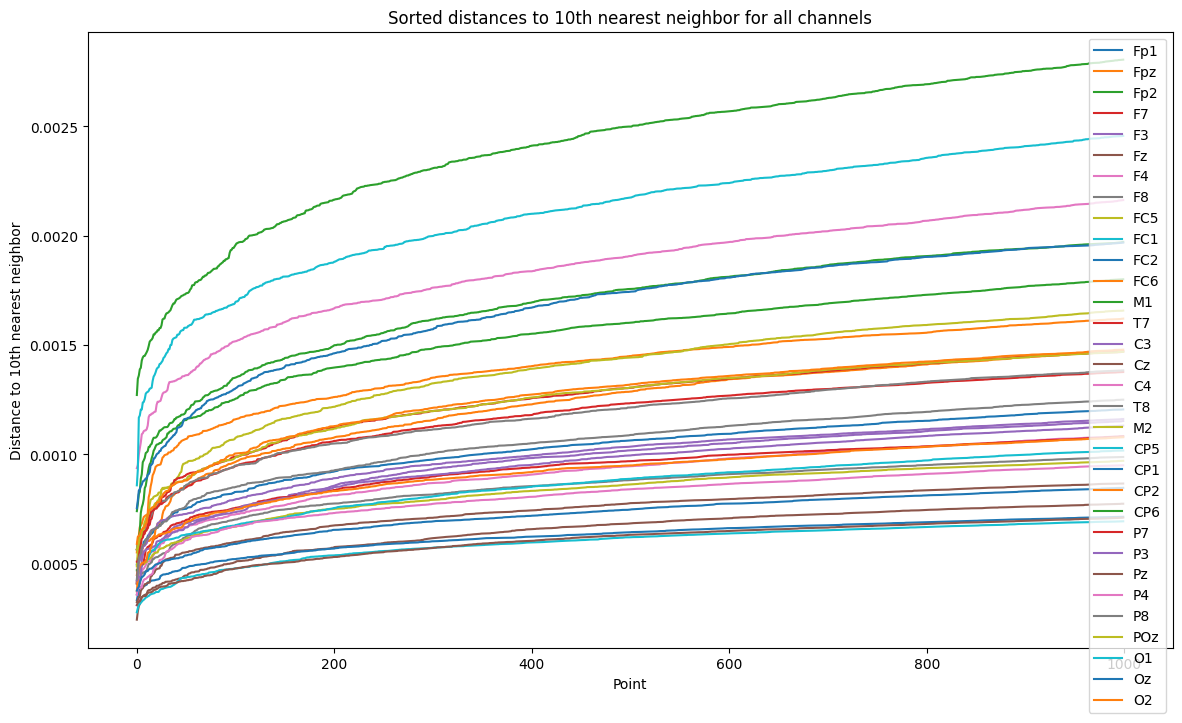

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import os

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'

# Load EEG data
EEG_data = np.load(os.path.join(base_dir, 'eeg_data_with_channels.npy'), allow_pickle=True)

sampling_rate = 1000  # Hz
start_time, end_time = 805.571, 921.515 # Data without stimulation occuring
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
filtered_EEG_data = EEG_data[start_index:end_index, :]

import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Define the min_samples value you plan to use with UMAP
min_samples = 10

# Load EEG data (the following is an example path, replace with the actual path to your EEG data)
EEG_data = filtered_EEG_data

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Create a figure for plotting
plt.figure(figsize=(14, 8))

# Loop through all channels and plot the elbow plot for each
for channel_index, channel_name in enumerate(eeg_channel_names):
    # Select the data for the current channel
    channel_data = EEG_data[:, channel_index].reshape(-1, 1)  # Reshape for NearestNeighbors
    
    neighbors = NearestNeighbors(n_neighbors=min_samples).fit(channel_data)
    distances, indices = neighbors.kneighbors(channel_data)

    # Sort the distances
    distances = np.sort(distances[:, min_samples-1], axis=0)

    # Plotting the elbow plot for the first 1000 points of the current channel
    plt.plot(distances[:1000], label=channel_name)

plt.xlabel('Point')
plt.ylabel('Distance to 10th nearest neighbor')
plt.title('Sorted distances to 10th nearest neighbor for all channels')
plt.legend(loc='upper right')  # Adjust the legend location so it doesn't overlap the lines
plt.show()

### UMAP and t-SNE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')
plots_dir = os.path.join(base_dir, 'plots')
embeddings_dir = os.path.join(base_dir, 'embeddings')

# Create directories for plots and embeddings if they don't exist
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(embeddings_dir, exist_ok=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Define the UMAP and t-SNE parameters
n_components_umap = 2
n_neighbors_umap = 15
min_dist_umap = 0.1
random_state_umap = 42

n_components_tsne = 2
perplexity_tsne = 30
random_state_tsne = 42

# Function to apply UMAP
def apply_umap(data, n_components, n_neighbors, min_dist, random_state):
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    embedding = reducer.fit_transform(data)
    return embedding

# Function to apply t-SNE
def apply_tsne(data, n_components, perplexity, random_state):
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        random_state=random_state
    )
    embedding = tsne.fit_transform(data)
    return embedding

# Loop through each channel's 3D embedded data
for channel_name in eeg_channel_names:
    data_path = os.path.join(embedding_3d_dir, f'3dembedded_{channel_name}.npy')
    channel_data_3d = np.load(data_path)
    
    # Apply UMAP and t-SNE to each channel's 3D embedded data
    umap_embedding = apply_umap(channel_data_3d, n_components_umap, n_neighbors_umap, min_dist_umap, random_state_umap)
    tsne_embedding = apply_tsne(channel_data_3d, n_components_tsne, perplexity_tsne, random_state_tsne)
    
    # Save the embeddings to .npy files
    np.save(os.path.join(embeddings_dir, f'umap_embedding_{channel_name}.npy'), umap_embedding)
    np.save(os.path.join(embeddings_dir, f'tsne_embedding_{channel_name}.npy'), tsne_embedding)
    
    # Create and save UMAP plot
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=5)
    plt.title(f'UMAP for {channel_name}')
    plt.savefig(os.path.join(plots_dir, f'UMAP_{channel_name}.png'))
    plt.close()  # Close the figure to free up memory
    
    # Create and save t-SNE plot
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=5)
    plt.title(f't-SNE for {channel_name}')
    plt.savefig(os.path.join(plots_dir, f'tSNE_{channel_name}.png'))
    plt.close()  # Close the figure to free up memory

/home/vincent/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/vincent/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/vincent/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/vincent/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed f

### Sample Entropy, Box Counting Dimension, 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import hdbscan
from scipy.spatial import cKDTree
import nolds
import pandas as pd

# Define the base directory for the UMAP embeddings
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_dir = os.path.join(base_dir, 'embeddings')

# EEG channel names corresponding to the UMAP embeddings
eeg_channel_names = ['C3', 'C4', 'CP1', 'CP2', 'CP5', 'CP6', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FC1', 'FC2', 'FC5', 'FC6', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'M1', 'M2', 'O1', 'O2', 'Oz', 'P3', 'P4', 'P7', 'P8', 'POz', 'Pz', 'T7', 'T8']

def sample_entropy_nolds(u, m=2, r=None):
    if r is None:
        r = 0.2 * np.std(u)
    return nolds.sampen(u, emb_dim=m, tolerance=r)

def correlation_dimension_nolds(data, emb_dim=10):
    # Flatten the data to make it a 1D time series
    data_flattened = data.flatten()
    # Calculate the correlation dimension
    corr_dim = nolds.corr_dim(data_flattened, emb_dim)
    return corr_dim

# Collect results
results = []

def analyze_channel_data_hdbscan(channel_data_2d, channel_name):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
    clusters = clusterer.fit_predict(channel_data_2d)
    
    sample_entropy_value = sample_entropy_nolds(channel_data_2d.flatten())
    
    corr_dim = correlation_dimension_nolds(channel_data_2d)

    
    results.append({
        "Channel": channel_name,
        "Number of Clusters": len(set(clusters)) - (1 if -1 in clusters else 0),
        "Sample Entropy": sample_entropy_value,
        "Correlation Dimension": corr_dim
    })

# Loop over each EEG channel's UMAP embedding
for channel_name in eeg_channel_names:
    data_path = os.path.join(embedding_dir, f'umap_embedding_{channel_name}.npy')
    channel_data_2d = np.load(data_path)
    
    analyze_channel_data_hdbscan(channel_data_2d, channel_name)

# Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(results)
csv_path = os.path.join(base_dir, 'analysis_results_umap.csv')
results_df.to_csv(csv_path, index=False)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].bar(results_df['Channel'], results_df['Number of Clusters'])
axs[0].set_title('Number of Clusters per Channel')
axs[0].tick_params(axis='x', rotation=90)
axs[1].bar(results_df['Channel'], results_df['Sample Entropy'])
axs[1].set_title('Sample Entropy per Channel')
axs[1].tick_params(axis='x', rotation=90)
axs[2].bar(results_df['Channel'], results_df['Correlation Dimension'])
axs[2].set_title('Correlation Dimension per Channel')
axs[2].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

### Phase space reconstruction using caos method

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import multiprocessing
import os
import zipfile
from minepy import MINE

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_2d_dir = os.path.join(base_dir, '2dembedding_data')
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')
plots_directory = os.path.join(base_dir, 'plots')

# Load EEG data
EEG_data = np.load(os.path.join(base_dir, 'eeg_data_with_channels.npy'), allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

sampling_rate = 1000  # Hz
start_time, end_time = 805.571, 921.515
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
filtered_EEG_data = EEG_data[start_index:end_index, :]

max_dim = 20

def mutual_info_worker(args):
    data1, data2 = args
    mine = MINE(alpha=0.6, c=15)
    mine.compute_score(data1, data2)
    return mine.mic()

def determine_delay(data, max_delay=100, subsample_factor=10):
    subsampled_data = data[::subsample_factor]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        mi_values = pool.map(mutual_info_worker, [(subsampled_data[:-i], subsampled_data[i:]) for i in range(1, max_delay + 1)])
    return np.argmin(mi_values) + 1

def delay_embedding(data, emb_dim, delay):
    N = len(data)
    return np.array([data[i:i + emb_dim * delay:delay] for i in range(N - (emb_dim - 1) * delay)])

def false_nearest_neighbors(data, emb_dim, delay, R=10):
    N = len(data)
    false_neighbors = np.zeros(emb_dim)
    for d in range(1, emb_dim + 1):
        emb_data = delay_embedding(data, d, delay)
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_data)
        distances, indices = nbrs.kneighbors(emb_data)
        false_neighbors[d - 1] = np.mean((np.abs(distances[:, 0] - distances[:, 1]) / distances[:, 1]) > R)
    return false_neighbors
    
def caos_method(data, max_dim=20, tau=1):
    def nearest_distance(embedded_data):
        """Compute the nearest distance for each point in the embedded data."""
        min_distances = np.full(len(embedded_data), np.inf)
        for i in range(len(embedded_data)):
            for j in range(len(embedded_data)):
                if i != j:
                    dist = np.sum((embedded_data[i] - embedded_data[j]) ** 2)
                    min_distances[i] = min(min_distances[i], dist)
        return np.sqrt(min_distances)

    def embedding(data, dim, tau):
        """Embeds data according to given dimension and time delay."""
        N = len(data)
        if N - (dim - 1) * tau < 1:
            return None
        embedded_data = np.array([data[i:N - (dim - 1) * tau + i:tau] for i in range(dim)]).T
        return embedded_data

    E1 = np.zeros(max_dim)
    E2 = np.zeros(max_dim - 1)

    for dim in range(1, max_dim + 1):
        embedded_data = embedding(data, dim, tau)
        if embedded_data is None:
            break

        min_distances = nearest_distance(embedded_data)
        if dim < max_dim:
            embedded_data_next = embedding(data, dim + 1, tau)
            min_distances_next = nearest_distance(embedded_data_next)
            E1[dim - 1] = np.mean(min_distances_next / min_distances[:-1])
            if dim > 1:
                E2[dim - 2] = E1[dim - 1] / E1[dim - 2]

    return E1, E2
    
# Analyze each EEG channel using Cao's method and generate plots
for channel_name in eeg_channel_names:
    channel_index = eeg_channel_names.index(channel_name)
    channel_data = filtered_EEG_data[:, channel_index]

    # Assuming optimal_delay is predefined or determined by another method
    optimal_delay = determine_delay(channel_data, max_delay=20, subsample_factor=10)

    # Determine the optimal embedding dimension using Cao's method
    E1, E2 = caos_method(channel_data, max_dim=20, tau=optimal_delay)
    optimal_dim = np.argmax(E2 < 1.05) + 2  # Adjust this criterion based on your analysis

    # Perform embedding with the determined optimal dimension
    embedded_data = delay_embedding(channel_data, emb_dim=optimal_dim, delay=optimal_delay)

    # Save the embedded data
    if optimal_dim == 2:
        np.save(os.path.join(embedding_2d_dir, f'2dembedded_{channel_name}.npy'), embedded_data)
    else:
        np.save(os.path.join(embedding_3d_dir, f'3dembedded_{channel_name}.npy'), embedded_data)

    # Generate and save plot for the optimal embedding
    if emb_dim == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(embedded_data[:, 0], embedded_data[:, 1], s=1)
        plt.title(f'2D Phase Space Reconstruction for {channel_name}')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.savefig(os.path.join(plots_directory, f'2D_{channel_name}.png'))
        plt.close()
    elif emb_dim == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], s=1)
        ax.set_title(f'3D Phase Space Reconstruction for {channel_name}')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        plt.savefig(os.path.join(plots_directory, f'3D_{channel_name}.png'))
        plt.close()

# Zip the embedded data directories
for dir_path, zip_name in [(embedding_2d_dir, '2d_embedded_data_caos.zip'), (embedding_3d_dir, '3d_embedded_data_caos.zip')]:
    with zipfile.ZipFile(os.path.join(base_dir, zip_name), 'w') as zipf:
        for file in os.listdir(dir_path):
            zipf.write(os.path.join(dir_path, file), file)

print("All processes completed successfully.")

### Topological data analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gudhi as gd
from umap import UMAP

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')
persistence_dir = os.path.join(base_dir, 'persistence_diagrams')
betti_plot_dir = os.path.join(base_dir, 'betti_plots')

# Create directories for persistence diagrams and Betti number plots if they don't exist
os.makedirs(persistence_dir, exist_ok=True)
os.makedirs(betti_plot_dir, exist_ok=True)

# List all .npy files in the directory
embedding_files = [file for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Define the UMAP parameters
n_components_umap = 2
random_state_umap = 42

def compute_persistence_diagrams(data):
    """
    Compute the persistence diagrams for a given dataset using Vietoris-Rips complex.
    :param data: Input dataset, assumed to be the output of a dimensionality reduction method.
    :return: Persistence diagrams for the dataset.
    """
    rips_complex = gd.RipsComplex(points=data, max_edge_length=2)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()
    return persistence

def plot_persistence_diagrams(persistence):
    """
    Plot the persistence diagrams.
    :param persistence: Persistence diagrams.
    """
    gd.plot_persistence_diagram(persistence)
    plt.show()

def calculate_betti_numbers(persistence):
    """
    Calculate Betti numbers from the persistence diagrams.
    :param persistence: Persistence diagrams.
    :return: Betti numbers (b0, b1, b2) counting the number of connected components, loops, and voids respectively.
    """
    betti_numbers = {i: 0 for i in range(3)}  # Assuming we're only interested in dimensions 0, 1, and 2
    for interval in persistence:
        if interval[0] < 3:  # Filter out infinite persistence intervals
            betti_numbers[interval[0]] += 1
    return betti_numbers[0], betti_numbers[1], betti_numbers[2]

def plot_betti_numbers(betti_numbers, channel_name):
    plt.bar(range(len(betti_numbers)), list(betti_numbers.values()), tick_label=list(betti_numbers.keys()))
    plt.title(f'Betti Numbers for {channel_name}')
    plt.ylabel('Betti Number')
    plt.xlabel('Dimension')
    plt.savefig(os.path.join(betti_plot_dir, f'Betti_{channel_name}.png'))
    plt.close()

# Define segment length for synthetic labels
segment_length = 1000  # Define this based on your specific needs

# Loop through each .npy file and perform analysis
for file in embedding_files:
    file_path = os.path.join(data_dir, file)
    channel_data_3d = np.load(file_path)
    
    # Perform UMAP dimensionality reduction
    umap_reducer = UMAP(n_components=2, random_state=42)
    reduced_data_umap = umap_reducer.fit_transform(channel_data_3d)

    # Synthetic labels for demonstration (alternating every `segment_length` samples)
    num_segments = reduced_data_umap.shape[0] // segment_length
    labels = np.array([i % 2 for i in range(num_segments) for _ in range(segment_length)])
    labels = np.pad(labels, (0, reduced_data_umap.shape[0] - len(labels)), 'edge')  # Pad labels if necessary

    # Ensure the length of `labels` matches the number of rows in `reduced_data_umap`
    assert len(labels) == reduced_data_umap.shape[0]

    # Compute Persistence Diagrams
    persistence = compute_persistence_diagrams(reduced_data_umap)
    
    # Save Persistence Diagrams
    np.save(os.path.join(persistence_dir, f'persistence_{channel_name}.npy'), np.array(persistence))

    # Plot Persistence Diagrams
    plot_persistence_diagrams(persistence)

    # Calculate Betti Numbers
    betti_numbers = calculate_betti_numbers(persistence)
    print(f"Betti Numbers for {file}:", betti_numbers)

    # Plot and save Betti Numbers
    plot_betti_numbers(betti_numbers, channel_name)

    # Assuming `reduced_data_umap` is now your features for machine learning
    X = reduced_data_umap
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(reduced_data_umap, labels, test_size=0.3, random_state=42)

    # Initialize and train the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy for {file}: {accuracy:.2f}")

### Lyapunov Exponents


In [5]:
import os
import nolds
import numpy as np

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Calculate the Lyapunov exponent for each file
for file_path in file_paths:
    # Load the embedding data from the file
    data = np.load(file_path)
    
    # Ensure data is in a compatible shape (one-dimensional, for example)
    if data.ndim > 1:
        # Example approach: flattening or selecting a single dimension
        # data = data.flatten()  # If flattening is appropriate
        data = data[:, 0]  # If selecting the first dimension is appropriate
    
    # Calculate the Lyapunov exponent with adjusted parameters
    try:
        lyap_exp = nolds.lyap_e(data, emb_dim=7, matrix_dim=3)
        print(f"Lyapunov Exponent for {os.path.basename(file_path)}: {lyap_exp}")
    except ValueError as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")

Lyapunov Exponent for 3dembedded_CP2.npy: [ 0.1001663  -0.0219188  -0.21810247]
Lyapunov Exponent for 3dembedded_Fp1.npy: [ 0.19647275  0.02226023 -0.20337339]
Lyapunov Exponent for 3dembedded_O2.npy: [ 0.19795118  0.02735571 -0.2032668 ]
Lyapunov Exponent for 3dembedded_Fpz.npy: [ 0.15226585  0.00386987 -0.21039629]
Lyapunov Exponent for 3dembedded_FC1.npy: [ 0.12120797 -0.00965013 -0.21473414]
Lyapunov Exponent for 3dembedded_T8.npy: [ 0.17768966  0.0163281  -0.20549665]
Lyapunov Exponent for 3dembedded_FC6.npy: [ 0.13305233 -0.0055372  -0.21391827]
Lyapunov Exponent for 3dembedded_POz.npy: [ 0.12713753 -0.00908613 -0.21416833]
Lyapunov Exponent for 3dembedded_Fp2.npy: [ 0.15001811  0.00124385 -0.21222056]
Lyapunov Exponent for 3dembedded_P3.npy: [ 0.13931774 -0.00197571 -0.21262725]
Lyapunov Exponent for 3dembedded_CP6.npy: [ 0.17250739  0.01311552 -0.21110822]
Lyapunov Exponent for 3dembedded_FC2.npy: [ 0.13367797 -0.0054545  -0.21452849]
Lyapunov Exponent for 3dembedded_P8.npy: [ 

### Lyapunov Exponents v.2

In [ ]:
import os
import nolds
import numpy as np

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# Prepare a dictionary to store Lyapunov exponents
lyapunov_exponents = {}

# List all .npy files in the directory and calculate Lyapunov exponent for each file
for file in os.listdir(embedding_3d_dir):
    if file.endswith('.npy'):
        file_path = os.path.join(embedding_3d_dir, file)
        data = np.load(file_path)
        if data.ndim > 1:
            data = data[:, 0]  # Select the first dimension
        try:
            lyap_exp = nolds.lyap_e(data, emb_dim=7, matrix_dim=3)
            lyapunov_exponents[os.path.splitext(file)[0]] = lyap_exp
        except ValueError as e:
            print(f"Error processing {file}: {e}")

# Now `lyapunov_exponents` contains all the Lyapunov exponent data

### Manually set exponent values

In [1]:
lyapunov_exponents = {
    '3dembedded_CP2': [0.1001663, -0.0219188, -0.21810247],
    '3dembedded_Fp1': [0.19647275, 0.02226023, -0.20337339],
    '3dembedded_O2': [0.19795118, 0.02735571, -0.2032668],
    '3dembedded_Fpz': [0.15226585, 0.00386987, -0.21039629],
    '3dembedded_FC1': [0.12120797, -0.00965013, -0.21473414],
    '3dembedded_T8': [0.17768966, 0.0163281, -0.20549665],
    '3dembedded_FC6': [0.13305233, -0.0055372, -0.21391827],
    '3dembedded_POz': [0.12713753, -0.00908613, -0.21416833],
    '3dembedded_Fp2': [0.15001811, 0.00124385, -0.21222056],
    '3dembedded_P3': [0.13931774, -0.00197571, -0.21262725],
    '3dembedded_CP6': [0.17250739, 0.01311552, -0.21110822],
    '3dembedded_FC2': [0.13367797, -0.0054545, -0.21452849],
    '3dembedded_P8': [0.23906457, 0.0404154, -0.20517926],
    '3dembedded_M1': [0.1726922, 0.01402679, -0.20617606],
    '3dembedded_Fz': [0.1444898, 0.000751, -0.21016128],
    '3dembedded_M2': [0.2400078, 0.04360552, -0.2002752],
    '3dembedded_C3': [0.13295792, -0.00343878, -0.21285893],
    '3dembedded_T7': [0.24657167, 0.04338904, -0.20185025],
    '3dembedded_F3': [0.2071598, 0.0273684, -0.19970714],
    '3dembedded_P4': [0.15047263, 0.00396656, -0.2098701],
    '3dembedded_C4': [0.10845525, -0.0181964, -0.2177281],
    '3dembedded_Oz': [0.16846396, 0.01381335, -0.20441212],
    '3dembedded_P7': [0.217658, 0.03200997, -0.20372498],
    '3dembedded_F7': [0.24611582, 0.03985837, -0.19719537],
    '3dembedded_CP5': [0.19272262, 0.02411257, -0.20332271],
    '3dembedded_F8': [0.16586016, 0.01130636, -0.20788962],
    '3dembedded_Pz': [0.11449838, -0.0140168, -0.21453662],
    '3dembedded_FC5': [0.20495647, 0.0277448, -0.19666697],
    '3dembedded_Cz': [0.11156336, -0.01590225, -0.21743171],
    '3dembedded_F4': [0.13353561, -0.0049214, -0.21504664],
    '3dembedded_CP1': [0.08591615, -0.02813494, -0.22101761],
    '3dembedded_O1': [0.13981585, -0.00206094, -0.21018599]
}


In [3]:
# Function to determine stability based on Lyapunov exponents
def determine_stability(lyapunov_exps):
    # If any exponent is positive, it's chaotic; otherwise, it's stable
    return 'chaotic' if any(exp > 0 for exp in lyapunov_exps) else 'stable'

# Creating the stability map
stability_map = {channel: determine_stability(exps) for channel, exps in lyapunov_exponents.items()}

# Displaying the stability map (optional)
for channel, stability in stability_map.items():
    print(f"{channel}: {stability}")

3dembedded_CP2: chaotic
3dembedded_Fp1: chaotic
3dembedded_O2: chaotic
3dembedded_Fpz: chaotic
3dembedded_FC1: chaotic
3dembedded_T8: chaotic
3dembedded_FC6: chaotic
3dembedded_POz: chaotic
3dembedded_Fp2: chaotic
3dembedded_P3: chaotic
3dembedded_CP6: chaotic
3dembedded_FC2: chaotic
3dembedded_P8: chaotic
3dembedded_M1: chaotic
3dembedded_Fz: chaotic
3dembedded_M2: chaotic
3dembedded_C3: chaotic
3dembedded_T7: chaotic
3dembedded_F3: chaotic
3dembedded_P4: chaotic
3dembedded_C4: chaotic
3dembedded_Oz: chaotic
3dembedded_P7: chaotic
3dembedded_F7: chaotic
3dembedded_CP5: chaotic
3dembedded_F8: chaotic
3dembedded_Pz: chaotic
3dembedded_FC5: chaotic
3dembedded_Cz: chaotic
3dembedded_F4: chaotic
3dembedded_CP1: chaotic
3dembedded_O1: chaotic


### Heatmap of Lyapunov Exponents

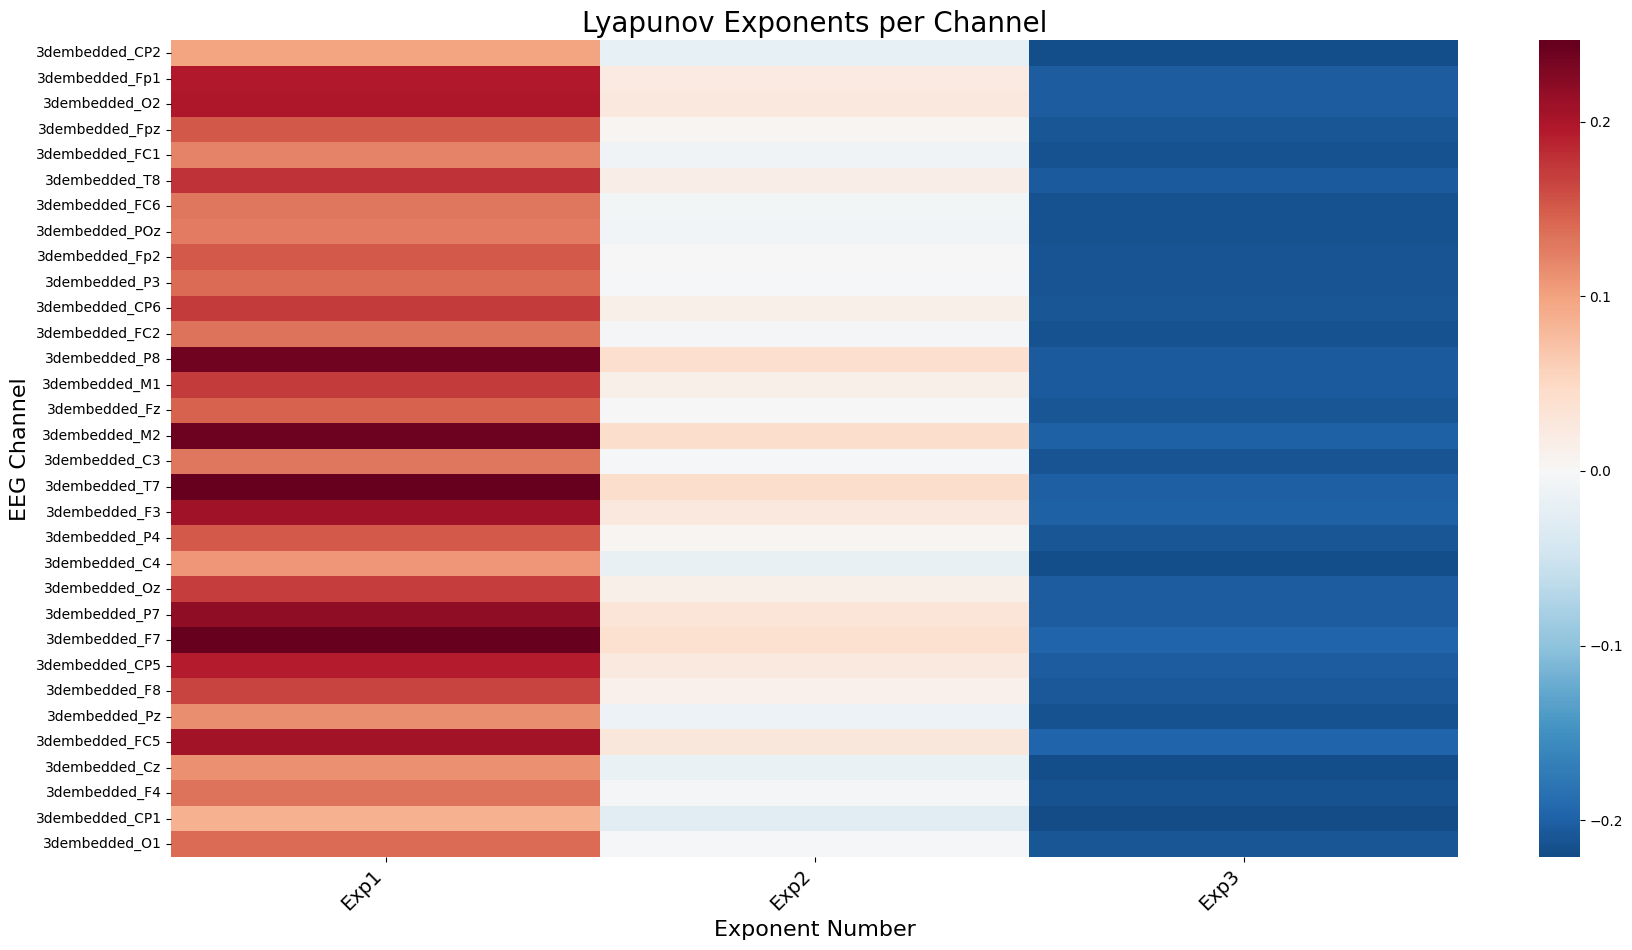

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
channels = list(lyapunov_exponents.keys())
exponents = list(lyapunov_exponents.values())
df_lyapunov = pd.DataFrame.from_dict(lyapunov_exponents, orient='index', columns=['Exp1', 'Exp2', 'Exp3'])

# Plot
plt.figure(figsize=(18, df_lyapunov.shape[0] * 0.3))  # Adjust the figure size based on the number of channels
# Create the heatmap without annotations
sns.heatmap(df_lyapunov, annot=False, cmap='RdBu_r', center=0)

# Set title and labels
plt.title('Lyapunov Exponents per Channel', fontsize=20)
plt.ylabel('EEG Channel', fontsize=16)
plt.xlabel('Exponent Number', fontsize=16)

# Rotate x-axis labels to show clearly, if needed
plt.xticks(rotation=45, ha='right', fontsize=14)

# Ensure the plot is displayed correctly with tight layout
plt.tight_layout()
plt.show()


### 3D Scatter Plot with Stability Label

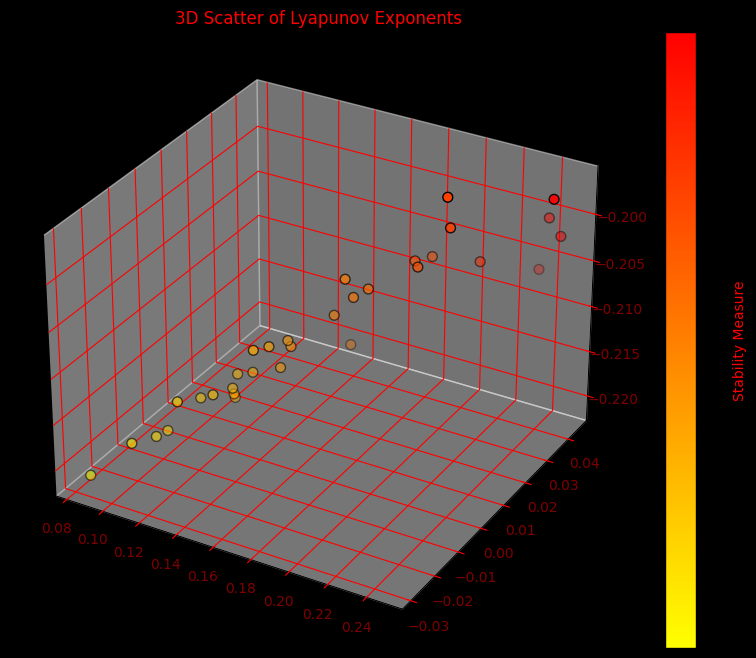

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define custom colormap
colors = [(1, 1, 0), (1, 0.5, 0), (1, 0, 0)]  # yellow, orange, red
cmap_name = 'yellow_orange_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

# Assuming lyapunov_exponents is a dictionary with your channels and their respective exponents
exponents = np.array(list(lyapunov_exponents.values()))

# Convert the first Lyapunov exponent to a stability measure between -1 and 1
# Assuming that more positive values indicate less stability (more chaotic)
stability_measure = exponents[:, 0] / max(abs(exponents[:, 0]))

# Plot
fig = plt.figure(figsize=(10, 8))
fig.patch.set_facecolor('black')  # Set the background color of the figure

ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')  # Set the background color of the plot area

# Create the scatter plot using the stability measure as the color
scatter = ax.scatter(exponents[:, 0], exponents[:, 1], exponents[:, 2], c=stability_measure, cmap=cm, s=50, edgecolor='black')

# Add color bar to indicate the scale of stability
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Stability Measure')
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
cbar.ax.yaxis.label.set_color('red')

# Set grid color to red with transparency
ax.xaxis._axinfo["grid"].update(color='red', alpha=0.5)
ax.yaxis._axinfo["grid"].update(color='red', alpha=0.5)
ax.zaxis._axinfo["grid"].update(color='red', alpha=0.5)

# Set grid face color to black
ax.xaxis._axinfo["grid"].update(grid_color='black')
ax.yaxis._axinfo["grid"].update(grid_color='black')
ax.zaxis._axinfo["grid"].update(grid_color='black')

# Set axis spine color to black
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Set tick color to red
ax.tick_params(axis='x', colors='red')
ax.tick_params(axis='y', colors='red')
ax.tick_params(axis='z', colors='red')

# Set label color to red
ax.xaxis.label.set_color('red')
ax.yaxis.label.set_color('red')
ax.zaxis.label.set_color('red')

# Set title color to red
ax.title.set_color('red')

# Set transparency for tick labels
plt.setp(ax.get_xticklabels(), color='red', alpha=0.5)
plt.setp(ax.get_yticklabels(), color='red', alpha=0.5)
plt.setp(ax.get_zticklabels(), color='red', alpha=0.5)

# Show plot
plt.title('3D Scatter of Lyapunov Exponents', color='red')
plt.show()


### Network Graph

In [ ]:
import networkx as nx

# Simulate connections (replace with actual connectivity data if available)
connections = [(channels[i], channels[i+1]) for i in range(len(channels)-1)]

# Create graph
G = nx.Graph()
G.add_edges_from(connections)

# Node colors
node_color = ['red' if stability_map[channel] == 'chaotic' else 'green' for channel in G.nodes()]

# Plot
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color=node_color, node_size=800, font_weight='bold', edge_color='gray')
plt.title('EEG Channel Stability Network')
plt.show()

### Bar Chart of Stability Counts

In [ ]:
from collections import Counter

# Count stability types
stability_counts = Counter(stability_map.values())

# Plot
plt.figure(figsize=(6, 4))
plt.bar(stability_counts.keys(), stability_counts.values(), color=['green', 'red'])
plt.title('Count of Stable vs Chaotic Channels')
plt.xlabel('Stability')
plt.ylabel('Count')
plt.show()

##### Lyapunov Exponents v.2

In [ ]:
import os
import nolds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a list to collect Lyapunov exponent results
lyap_results = []

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Calculate the Lyapunov exponent for each file
for file_path in file_paths:
    # Load the embedding data from the file
    data = np.load(file_path)
    
    # Ensure data is in a compatible shape (one-dimensional, for example)
    if data.ndim > 1:
        data = data[:, 0]  # Selecting the first dimension
        
    # Calculate the Lyapunov exponent with adjusted parameters
    try:
        lyap_exp = nolds.lyap_e(data, emb_dim=7, matrix_dim=3)
        # Store the results along with the file name
        lyap_results.append({'File': os.path.basename(file_path), 'Dim1': lyap_exp[0], 'Dim2': lyap_exp[1], 'Dim3': lyap_exp[2]})
    except ValueError as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")

# Convert the list of results to a DataFrame
lyap_exponents_df = pd.DataFrame(lyap_results)

# Define columns for visualization
columns = ['Dim1', 'Dim2', 'Dim3']

# Descriptive Statistics
descriptive_stats = lyap_exponents_df.describe()

# Plotting the distribution
plt.figure(figsize=(12, 6))
for column in columns:
    sns.kdeplot(lyap_exponents_df[column], label=column, shade=True)
plt.title('Distribution of Lyapunov Exponents')
plt.xlabel('Lyapunov Exponent Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Correlation matrix visualization
plt.figure(figsize=(6, 5))
sns.heatmap(lyap_exponents_df[columns].corr(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Lyapunov Exponents')
plt.show()

plt.figure(figsize=(12, 6))
for column in columns:
    plt.hist(lyap_exponents_df[column], alpha=0.5, label=column, bins=15, density=True)
plt.title('Distribution of Lyapunov Exponents')
plt.xlabel('Lyapunov Exponent Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Re-display the descriptive statistics
print(descriptive_stats)

### Find Optimised Parameters 

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.signal import coherence
from itertools import combinations
import os
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq

def preprocess_eeg(embedded_eeg_data):
    # Placeholder for any preprocessing needed
    return embedded_eeg_data

# Preprocess the embedded data if necessary (e.g., filtering)
preprocessed_data = preprocess_eeg(embedded_eeg_data)

# Function to estimate wave numbers (k) and growth rates (sigma) from dominant frequencies
def estimate_k_sigma(dominant_freqs, v=1.0):
    """
    Estimate wave numbers (k) and growth rates (sigma) from dominant frequencies.
    """
    # Calculate wave numbers 'k' based on dominant frequencies and a velocity 'v'
    k_values = 2 * np.pi * np.array(dominant_freqs) / v
    # Example empirical relationship for sigma, adjust according to your model
    # Estimate growth rates 'sigma' using an empirical relationship (example shown)
    sigma_values = np.exp(-0.1 * k_values)  
    return k_values, sigma_values

# Function to compute the Fourier Transform of EEG data
def compute_fourier_transform(preprocessed_data, sampling_rate):
    """
    Compute the Fourier Transform of the EEG data.
    Returns the frequency spectrum and corresponding frequencies.
    """
    # Compute the Fast Fourier Transform (FFT) of the data
    eeg_fft = fft(preprocessed_data)
    # Calculate frequencies for each FFT bin using the FFT frequency function
    frequencies = fftfreq(preprocessed_data.size, d=1/sampling_rate)
    return eeg_fft, frequencies

# Function to identify dominant frequencies in the EEG spectrum
def identify_dominant_frequencies(eeg_fft, frequencies):
    """
    Identify dominant frequencies in the EEG data from the Fourier spectrum.
    """
    # Calculate magnitude of the FFT (spectral power) to identify strong frequencies
    # Assuming eeg_fft is already calculated
    spectrum_magnitude = np.abs(eeg_fft)
    # Select top 5 dominant frequencies based on their magnitudes
    dominant_freqs = frequencies[np.argsort(spectrum_magnitude)[-5:]]  # Top 5 for example
    return dominant_freqs

# Load your embedded EEG data
sampling_rate = 1000  # Hz, adjust as necessary
embedded_eeg_data = np.load('path_to_your_embedded_data.npy')

# Step 1: Preprocess the EEG data (if necessary)
preprocessed_data = preprocess_eeg(embedded_eeg_data)

# Step 2 & 3: Compute Fourier Transform and identify dominant frequencies
eeg_fft, frequencies = compute_fourier_transform(preprocessed_data, sampling_rate)
dominant_freqs = identify_dominant_frequencies(eeg_fft, frequencies)

# Define supporting functions
def plv_to_time_delay(plv, lowest_freq=1):
    """
    Convert Phase Locking Value to time delay.
    """
    # Calculate the maximum delay based on the lowest frequency of interest
    max_delay = (1 / lowest_freq) / 2
    # Calculate and return the time delay as a function of the Phase Locking Value (PLV)
    return (1 - plv) * max_delay

def calculate_spatial_decay(EEG_data, sampling_rate):
    """
    Approximate the spatial decay rate based on the average coherence between EEG channels.
    """
    # Determine the number of channels in the EEG data
    n_channels = EEG_data.shape[0]
    # Calculate coherence between all unique pairs of EEG channels and take their average
    coherence_values = [np.mean(coherence(EEG_data[i], EEG_data[j], fs=sampling_rate)[1])
                        for i, j in combinations(range(n_channels), 2)]
    # Calculate the average coherence across all channel pairs
    average_coherence = np.mean(coherence_values)
    # Return the inverse of average coherence as the spatial decay rate, handling division by zero
    return 1 / average_coherence if average_coherence != 0 else np.inf

def calculate_synaptic_strengths(EEG_data, sampling_rate):
    """
    Estimate synaptic strengths based on the average coherence between pairs of EEG channels.
    """
    # Get the number of channels from EEG data dimensions
    n_channels = EEG_data.shape[0]
    # Calculate and collect the average coherence between each unique pair of EEG channels
    synaptic_strengths = [np.mean(coherence(EEG_data[i], EEG_data[j], fs=sampling_rate)[1])
                          for i, j in combinations(range(n_channels), 2)]
    # Return the overall average of the calculated synaptic strengths
    return np.mean(synaptic_strengths)


def calculate_propagation_delays(plv_matrix, frequency):
    """
    Estimate propagation delays from a matrix of phase locking values.
    """
    # Calculate the phase difference for each element in the PLV matrix using arccos
    phase_differences = np.arccos(plv_matrix)
    # Calculate the propagation delay for each phase difference based on the given frequency
    delays = phase_differences / (2 * np.pi * frequency)
    # Return the average of all calculated propagation delays
    return np.mean(delays)

# Load PLV matrix
plv_matrix_path = os.path.join('/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net/Analysis/Phase_Syncronization', 'plv_matrix.npy') 
plv_matrix = np.load(plv_matrix_path)

# Define the Gaussian kernel function for spatial interactions
def phi(x, r):
    # Returns the value of the Gaussian kernel for a given distance 'x' and spatial decay rate 'r'
    return np.exp(-r * x**2)

# Define the firing rate function, representing the neural response
def F(u, beta=1, theta=0):
    # Calculates the firing rate of neurons based on input 'u', steepness 'beta', and threshold 'theta'
    # This is the logistic (sigmoid) activation function
    return 1 / (1 + np.exp(-beta * (u - theta)))

# Amari model simulation function incorporating full dynamics
def amari_model(t, u, Nx, dx, epsilon, r, beta, theta, dominant_freqs):
    """
    Full Amari model simulation function, incorporating the influence of dominant frequencies.

    :param t: Time variable for the ODE solver.
    :param u: Neural field activity at the current time step.
    :param Nx: Number of spatial points in the neural field.
    :param dx: Spatial resolution.
    :param epsilon: Parameter representing the velocity of signal propagation.
    :param r: Spatial decay rate of the synaptic kernel.
    :param beta: Steepness of the firing rate function.
    :param theta: Threshold of the firing rate function.
    :param dominant_freqs: Array of dominant frequencies identified in the EEG data.
    :return: Time derivative of neural activity.
    """
    # Initialize an array for the time derivative of neural activity with zeros, size of 'Nx'
    du_dt = np.zeros(Nx)

    # Create an array 'x' representing spatial points, evenly spaced in the neural field
    x = np.linspace(-Nx/2, Nx/2, Nx) * dx

    # Compute the Fourier transform of the current state 'u' of the neural field
    u_fft = np.fft.fft(u)

    # Loop over each dominant frequency to modify the Fourier transform based on model dynamics
    for freq in dominant_freqs:
        # Calculate the wave number 'k' from frequency
        k = 2 * np.pi * freq
        # Calculate a simplified growth rate 'sigma' as a function of 'epsilon' and wave number 'k'
        sigma = np.exp(-epsilon * np.abs(k))
        # Apply the growth rate 'sigma' to modulate the Fourier transform
        u_fft *= sigma

    # Perform an inverse Fourier transform to convert back to spatial domain
    u_filtered = np.fft.ifft(u_fft)

    # Compute the interaction term for each spatial point using convolution with the Gaussian kernel
    for i in range(Nx):
        interaction_term = 0
        for j in range(Nx):
            # Calculate the distance between points 'i' and 'j'
            distance = np.abs(x[i] - x[j])
            # Convolve the filtered signal 'u_filtered' with the Gaussian kernel 'phi'
            interaction_term += phi(distance, r) * F(u_filtered[j], beta, theta) * dx
        # Update the time derivative of neural activity 'du_dt' based on the interaction term
        du_dt[i] = -u[i] + interaction_term

    # Return the real part of the derivative to ensure the result is not complex
    return du_dt.real

# Cost function for optimization
def cost_function(params, t, Nx, dx, actual_eeg_data):
    # Simulate EEG with the Amari model
    simulated_eeg = amari_model(t, params, Nx, dx, *params, k_values, sigma_values)

    # Example: Compare only the first channel of the actual EEG data
    # This is an illustrative example; in practice, you'd want a more robust comparison
    # Summarize actual EEG data in a comparable way (e.g., averaging across channels)
    summarized_actual_eeg = np.mean(actual_eeg_data, axis=1)  # Averaging across channels
    
    # Ensure the length matches the simulation time steps
    if summarized_actual_eeg.shape[0] != simulated_eeg.shape[0]:
        # Adjust data as needed, e.g., by truncating or interpolating
        # Placeholder adjustment, implement based on your actual needs
        summarized_actual_eeg = summarized_actual_eeg[:simulated_eeg.shape[0]]

    # Compute the mean squared error
    mse = np.mean((simulated_eeg[:,0] - summarized_actual_eeg) ** 2)  # Focus on comparable dimensions
    return mse

# Parameters for simulation
t_max = 10     # Total simulation time
dt = 0.1       # Time step
Nx = 50        # Number of spatial points
dx = 0.1       # Spatial resolution
t = np.arange(0, t_max, dt)

# Initial guess for model parameters: [epsilon, r, beta, theta]
# Define initial guesses for the model parameters: epsilon (propagation velocity), r (spatial decay rate),
# beta (steepness of the firing rate function), and theta (threshold of the firing rate function)
initial_params = [1.0, 0.1, 1.0, 0]

# Integration with identified wave numbers and growth rates
# Identify dominant frequencies from the EEG data's Fourier Transform
dominant_freqs = identify_dominant_frequencies(eeg_fft, frequencies)
# Estimate wave numbers (k) and growth rates (sigma) for the identified dominant frequencies
k_values, sigma_values = estimate_k_sigma(dominant_freqs)

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

# EEG channel names
# List of EEG channel names, representing different positions on the scalp
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

# Define the sampling rate of the EEG data
sampling_rate = 1000  # Hz
# Define start and end times for a specific segment of EEG data of interest
start_time, end_time = 805.571, 921.515
# Convert start and end times to indices based on the sampling rate
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
# Filter the EEG data to include only the specified time range
filtered_EEG_data = EEG_data[start_index:end_index, :]

# Generate an initial condition for neural activity, a random array of length 50
initial_condition = np.random.randn(50)
# Define time points for the simulation, from 0 to 10 in 100 steps
times = np.linspace(0, 10, 100)
# Define the number of spatial points (Nx) and spatial resolution (dx) for the simulation
Nx, dx = 50, 0.1
# (Repeated) Define initial guesses for the model parameters (this line appears to be redundant and might be removed)
initial_params = [1.0, 0.1, 1.0, 0]

# Use the 'minimize' function to find the model parameters that best fit the filtered EEG data,
# by minimizing the cost function. 'L-BFGS-B' is the optimization method used.
result = minimize(cost_function, initial_params, args=(times, Nx, dx, filtered_EEG_data, k_values, sigma_values), method='L-BFGS-B')
# Print the optimized parameters found by the minimization process
print("Optimized Parameters:", result.x)

Cluster analysis to group files or conditions with similar Lyapunov exponent profile

statistical tests to compare the distributions of Lyapunov exponents across different conditions or groups

Dynamical Systems Analysis

Correlation Dimension

Poincaré Maps

Stable States

Transition Dynamics

State Estimation

Vector Field Reconstruction

Differential Equations

### Katz Fractal Dimension


In [4]:
import os
import numpy as np

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

def katz_fd(data):
    # Assuming data is 2D (time x dimensions) or 3D
    if data.ndim > 1:
        # Calculate the Euclidean distance between consecutive points in multi-dimensional space
        distances = np.sqrt(np.sum(np.diff(data, axis=0)**2, axis=1))
        L = np.sum(distances)
        d = np.sqrt(np.sum((data[-1] - data[0])**2))
        FD = np.log10(len(data)) / (np.log10(d) + np.log10(L/d))
        return FD
    else:
        # Fallback for 1-dimensional data
        n = len(data)
        distances = np.abs(np.diff(data))
        L = np.sum(distances)
        d = np.abs(data[-1] - data[0])
        FD = np.log10(n) / (np.log10(d) + np.log10(L/d))
        return FD

# Calculate the Katz Fractal Dimension for each .npy file in your directory
for file_path in file_paths:
    data = np.load(file_path)
    fd = katz_fd(data)
    print(f"Katz Fractal Dimension for {os.path.basename(file_path)}: {fd}")

Katz Fractal Dimension for 3dembedded_CP2.npy: 0.7895851903276594
Katz Fractal Dimension for 3dembedded_Fp1.npy: 0.7557835643360691
Katz Fractal Dimension for 3dembedded_O2.npy: 0.7771451008407473
Katz Fractal Dimension for 3dembedded_Fpz.npy: 0.7694965424736298
Katz Fractal Dimension for 3dembedded_FC1.npy: 0.754666467166447
Katz Fractal Dimension for 3dembedded_T8.npy: 0.775860631705904
Katz Fractal Dimension for 3dembedded_FC6.npy: 0.7778944301162801
Katz Fractal Dimension for 3dembedded_POz.npy: 0.7811112731953377
Katz Fractal Dimension for 3dembedded_Fp2.npy: 0.7778921202581527
Katz Fractal Dimension for 3dembedded_P3.npy: 0.7703383799542355
Katz Fractal Dimension for 3dembedded_CP6.npy: 0.7777569704350933
Katz Fractal Dimension for 3dembedded_FC2.npy: 0.7842665641844162
Katz Fractal Dimension for 3dembedded_P8.npy: 0.7779463678317344
Katz Fractal Dimension for 3dembedded_M1.npy: 0.780969871019463
Katz Fractal Dimension for 3dembedded_Fz.npy: 0.7719120543992704
Katz Fractal Dimens

### Multiscale Entropy


In [1]:
import os
import numpy as np
import nolds

def coarse_grain(time_series, scale):
    """Create coarse-grained time series."""
    n = len(time_series)
    if n % scale == 0:
        m = n // scale
    else:
        m = n // scale + 1  # ensure that the length of the coarse-grained time series is sufficient
    coarse_ts = np.zeros(m)
    for i in range(m):
        start = i * scale
        end = min(start + scale, n)
        coarse_ts[i] = np.mean(time_series[start:end])
    return coarse_ts

def multiscale_entropy(time_series, max_scale, emb_dim=2, tolerance='default'):
    """Compute multiscale entropy of the given time series."""
    mse = np.zeros(max_scale)
    for scale in range(1, max_scale + 1):
        coarse_ts = coarse_grain(time_series, scale)
        if tolerance == 'default':
            # Set tolerance to 0.1 times the standard deviation of the original time series.
            tolerance = 0.1 * np.std(time_series)
        mse[scale-1] = nolds.sampen(coarse_ts, emb_dim=emb_dim, tolerance=tolerance)
    return mse

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Parameters
max_scale = 5  # Maximum scale factor to compute MSE
emb_dim = 2  # Embedding dimension for Sample Entropy

# Calculate MSE for each file and each dimension
for file_path in file_paths:
    data = np.load(file_path)
    print(f"Processing {os.path.basename(file_path)}")
    for dim in range(data.shape[1]):  # Assuming data is of shape (time, dimensions)
        mse = multiscale_entropy(data[:, dim], max_scale, emb_dim)
        print(f"  MSE for dimension {dim+1}: {mse}")

Processing 3dembedded_CP2.npy
  MSE for dimension 1: [0.53632    0.75532459 0.59880673 0.49959914 0.55631718]
  MSE for dimension 2: [0.53684296 0.75564646 0.60010727 0.49951403 0.55183201]
  MSE for dimension 3: [0.53782133 0.75753848 0.60102756 0.49910913 0.55685376]
Processing 3dembedded_Fp1.npy
  MSE for dimension 1: [0.03493226 0.03696278 0.03493857 0.03579038 0.03195549]
  MSE for dimension 2: [0.03504147 0.03698091 0.03511961 0.03594636 0.03216243]
  MSE for dimension 3: [0.03517006 0.03719568 0.03522293 0.03597956 0.03225309]
Processing 3dembedded_O2.npy
  MSE for dimension 1: [0.366427   0.45919312 0.45359565 0.43635412 0.41515162]
  MSE for dimension 2: [0.3672517  0.46032518 0.45463392 0.43825002 0.41701303]
  MSE for dimension 3: [0.36750774 0.46067627 0.45661193 0.43765352 0.41398176]
Processing 3dembedded_Fpz.npy
  MSE for dimension 1: [0.08524483 0.08946133 0.08518291 0.08882016 0.07948981]
  MSE for dimension 2: [0.08543638 0.08960738 0.08542945 0.08914518 0.07973478]
 

### Multiscale Entropy v.2

In [ ]:
import os
import numpy as np
import nolds
import matplotlib.pyplot as plt
import pandas as pd

def coarse_grain(time_series, scale):
    """Create coarse-grained time series."""
    n = len(time_series)
    if n % scale == 0:
        m = n // scale
    else:
        m = n // scale + 1
    coarse_ts = np.zeros(m)
    for i in range(m):
        start = i * scale
        end = min(start + scale, n)
        coarse_ts[i] = np.mean(time_series[start:end])
    return coarse_ts

def multiscale_entropy(time_series, max_scale, emb_dim=2, tolerance='default'):
    """Compute multiscale entropy of the given time series."""
    mse = np.zeros(max_scale)
    for scale in range(1, max_scale + 1):
        coarse_ts = coarse_grain(time_series, scale)
        if tolerance == 'default':
            tolerance = 0.1 * np.std(time_series)
        mse[scale-1] = nolds.sampen(coarse_ts, emb_dim=emb_dim, tolerance=tolerance)
    return mse

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Parameters
max_scale = 5
emb_dim = 2

# Collecting MSE results
mse_results = {}

for file_path in file_paths:
    data = np.load(file_path)
    file_name = os.path.basename(file_path)
    print(f"Processing {file_name}")
    for dim in range(data.shape[1]):  # Assuming data is of shape (time, dimensions)
        mse = multiscale_entropy(data[:, dim], max_scale, emb_dim)
        mse_results[f"{file_name}_Dim{dim+1}"] = mse
        print(f"  MSE for dimension {dim+1}: {mse}")

# Plotting MSE results
n_files = len(mse_results)
fig, axs = plt.subplots(n_files, 1, figsize=(10, 5*n_files), squeeze=False)
for i, (key, mse_values) in enumerate(mse_results.items()):
    scales = range(1, max_scale + 1)
    axs[i, 0].plot(scales, mse_values, marker='o', linestyle='-')
    axs[i, 0].set_title(f'Multiscale Entropy for {key}')
    axs[i, 0].set_xlabel('Scale Factor')
    axs[i, 0].set_ylabel('Sample Entropy')
    axs[i, 0].grid(True)

plt.tight_layout()
plt.show()

# Optionally, save MSE results to a CSV file
mse_df = pd.DataFrame.from_dict(mse_results, orient='index')
mse_df.to_csv('/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net/mse_results.csv')

### Wavelet-Based Fractal Analysis

In [2]:
import numpy as np
import pywt
import os

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

sampling_rate = 1000  # Hz
start_time, end_time = 805.571, 921.515 # Data without stimulation occuring
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
filtered_EEG_data = EEG_data[start_index:end_index, :]

# Function to estimate Hurst exponent from wavelet coefficients
def estimate_hurst_exponent(coeffs):
    levels = len(coeffs) - 1
    n = np.array([2 ** i for i in range(1, levels + 1)])
    S = np.array([np.std(coeffs[i], ddof=1) for i in range(1, levels + 1)])
    coeffs = np.polyfit(np.log2(n), np.log2(S), 1)
    hurst = coeffs[0]
    return hurst

# Function for wavelet-based fractal analysis on a single channel
def wavelet_fractal_analysis(signal, wavelet='db4'):
    coeffs = pywt.wavedec(signal, wavelet)
    hurst_exponent = estimate_hurst_exponent(coeffs)
    return hurst_exponent

# Calculate and store Hurst exponent for each channel
hurst_exponents = np.zeros(len(eeg_channel_names))
for i, channel in enumerate(eeg_channel_names):
    signal = EEG_data[:, i]
    hurst_exponents[i] = wavelet_fractal_analysis(signal)
    print(f"Hurst exponent for {channel}: {hurst_exponents[i]}")


Hurst exponent for Fp1: -0.7302666273352378
Hurst exponent for Fpz: -0.7340831953834842
Hurst exponent for Fp2: -0.7347167513839757
Hurst exponent for F7: -0.7093522939528786
Hurst exponent for F3: -0.6707034245230302
Hurst exponent for Fz: -0.7321734729355163
Hurst exponent for F4: -0.7437842146375412
Hurst exponent for F8: -0.6739569386591142
Hurst exponent for FC5: -0.6914129655563076
Hurst exponent for FC1: -0.7329135844120692
Hurst exponent for FC2: -0.7358078956827542
Hurst exponent for FC6: -0.6666923410569758
Hurst exponent for M1: -0.68366342928111
Hurst exponent for T7: -0.6106584469337303
Hurst exponent for C3: -0.6625931427742711
Hurst exponent for Cz: -0.6900598438321234
Hurst exponent for C4: -0.6677376565495038
Hurst exponent for T8: -0.6649268763194146
Hurst exponent for M2: -0.6708315703962102
Hurst exponent for CP5: -0.49354978521656256
Hurst exponent for CP1: -0.6408133835853129
Hurst exponent for CP2: -0.6361934472100145
Hurst exponent for CP6: -0.6615030864841843
H

### Approximate Entropy


### Local Fractal Dimension


### Fractal Dimension of Network Connectivity

# Time Series Analysis


### 

### Hamiltonian Matrix Construction

In this approach, the construction of a Hamiltonian matrix to analyze EEG data draws on quantum mechanics principles to encapsulate both the dynamic and static properties of brain activity, represented by EEG signals. By calculating kinetic and potential energy from the signal's time-series data, and integrating frequency domain analyses through Fourier transforms, we mirror the energy considerations central to quantum systems. Temporal symmetry, evaluated via signal autocorrelation and the correlation between original and time-reversed signals, parallels the time-reversal symmetry observed in quantum mechanics. The Hamiltonian's diagonal elements are populated with these energy and symmetry metrics for individual EEG channels, while off-diagonal elements are determined by the correlation coefficients between different channels, reflecting interaction energies. This matrix then undergoes normalization to ensure comparability, culminating in a heatmap visualization that offers a macroscopic view of the brain's complex, quantum-like interactions. This methodology, rooted in the quantum mechanical framework, aims to provide deeper insights into the neural dynamics underlying EEG data, potentially revealing novel patterns and characteristics of brain function.

Hamiltonian Matrix Basic Statistics:
Minimum Value: -0.9904138083412245
Maximum Value: 57744977447077.766
Average Value: 250819493693.32257
Hamiltonian matrix saved to /home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net/Hamiltonian_Matrix.npy


/tmp/ipykernel_773173/375596665.py:96: RuntimeWarning: invalid value encountered in divide
  scaled_values = (values - min_val) / (max_val - min_val)


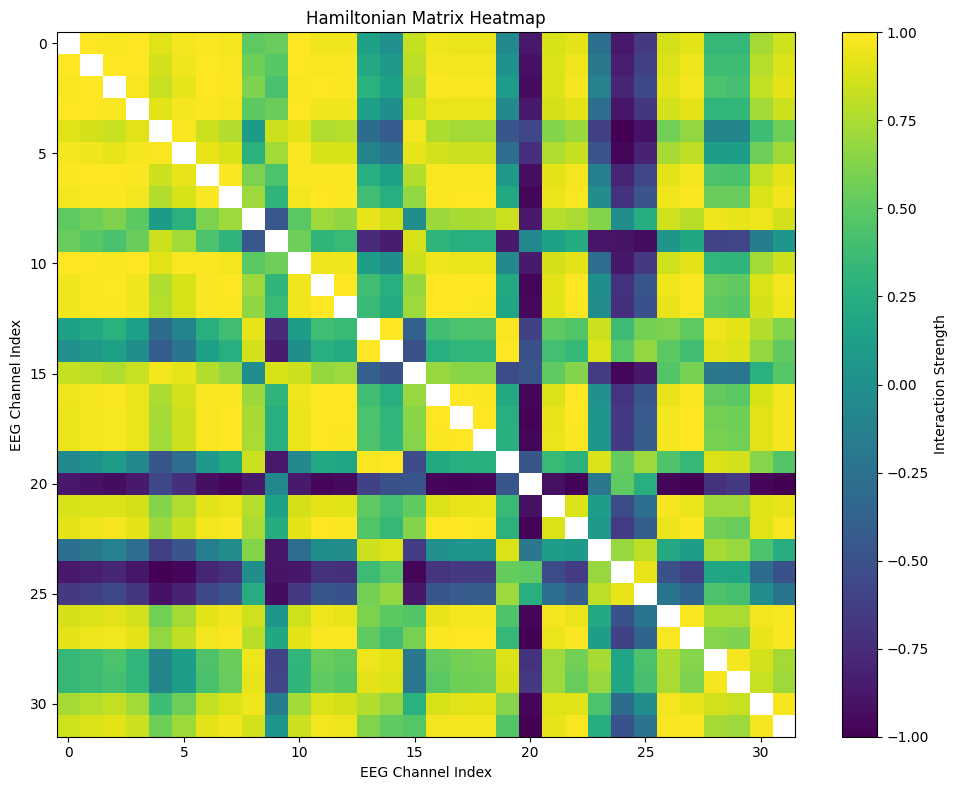

In [1]:
import numpy as np
import os
from numpy.fft import fft
import matplotlib.pyplot as plt

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

sampling_rate = 1000  # Hz (adjust if necessary) - The sampling rate of the EEG data
start_time, end_time = 805.571, 921.515  # Start and end times for the data segment to analyze
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)  # Convert times to indices
EEG_data = EEG_data[start_index:end_index, :]  # Extract the segment of EEG data for analysis

# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

def calculate_energy_features(EEG_signal):
    # This function calculates kinetic and potential energy, and the mean frequency content of an EEG signal
    kinetic_energy = np.sum(np.diff(EEG_signal) ** 2) / len(EEG_signal)  # Kinetic energy based on signal changes
    potential_energy = np.sum(EEG_signal ** 2) / len(EEG_signal)  # Potential energy based on signal magnitude
    freq_content = np.abs(fft(EEG_signal)) ** 2  # Frequency content, squared to get power spectrum
    return kinetic_energy, potential_energy, freq_content.mean()  # Return energies and average frequency power


def calculate_temporal_symmetry(signal):
    """
    Calculate the temporal symmetry of a signal by comparing it to its time-reversed version.
    
    Args:
    - signal (np.ndarray): The signal to analyze.
    
    Returns:
    - symmetry_score (float): A score representing the degree of temporal symmetry.
    """
    # This function calculates the temporal symmetry of a signal
    time_reversed_signal = signal[::-1]  # Reverse the signal for comparison
    symmetry_score = np.corrcoef(signal, time_reversed_signal)[0, 1]  # Correlation coefficient as symmetry score
    return symmetry_score

# Define symmetric channel pairs based on the EEG electrode layout
channel_pairs = [('F3', 'F4'), ('T7', 'T8'), ('C3', 'C4'), ('P3', 'P4'), ('O1', 'O2')]
channel_indices_pairs = [(eeg_channel_names.index(pair[0]), eeg_channel_names.index(pair[1])) for pair in channel_pairs]

num_channels = EEG_data.shape[1] 
H = np.zeros((num_channels, num_channels))

# Adjust diagonal elements for temporal symmetry
for i in range(num_channels):
    signal = EEG_data[i]
    autocorr = np.correlate(signal, signal, mode='full')[-signal.size:]
    temporal_symmetry_metric = np.max(autocorr)
    H[i, i] += temporal_symmetry_metric  # Adding temporal symmetry to initial values

# Calculate diagonal elements: energy features + temporal symmetry for each channel
for i in range(num_channels):
    signal = EEG_data[:, i]  # Correct extraction of channel data
    kinetic, potential, freq_mean = calculate_energy_features(signal)
    temporal_symmetry = calculate_temporal_symmetry(signal)  # Calculate temporal symmetry score
    # Incorporate temporal symmetry into the Hamiltonian matrix.
    # You might directly add the score or scale it appropriately.
    H[i, i] = kinetic + potential + freq_mean + temporal_symmetry

# Off-diagonal elements: based on correlations, including bilateral symmetry
correlation_matrix = np.corrcoef(EEG_data.T)  # Correctly compute correlations between channels

# Bilateral symmetry adjustments
for i, j in channel_indices_pairs:
    H[i, j] = H[j, i] = correlation_matrix[i, j]

for i in range(num_channels):
    for j in range(num_channels):
        if i != j:  # Avoid diagonal; already calculated
            H[i, j] = correlation_matrix[i, j]  # Populate with correlation values

# Print basic statistics of the Hamiltonian matrix
print("Hamiltonian Matrix Basic Statistics:")
print(f"Minimum Value: {np.min(H)}")
print(f"Maximum Value: {np.max(H)}")
print(f"Average Value: {np.mean(H)}")

# Define the save path
save_path = os.path.join(base_dir, 'Hamiltonian_Matrix.npy')
# Save the Hamiltonian matrix
np.save(save_path, H)
print(f"Hamiltonian matrix saved to {save_path}")

def normalize_to_range(values, new_min=0, new_max=1):
    """
    Normalize an array of values to a new range [new_min, new_max].
    """
    min_val = np.min(values)
    max_val = np.max(values)
    scaled_values = (values - min_val) / (max_val - min_val)
    return new_min + scaled_values * (new_max - new_min)

# Calculate the upper triangular indices once, excluding the diagonal
tri_u_indices = np.triu_indices(num_channels, k=1)

for i in range(num_channels):
    signal = EEG_data[:, i]
    kinetic, potential, freq_mean = calculate_energy_features(signal)
    kinetic_normalized = normalize_to_range(np.array([kinetic]))
    potential_normalized = normalize_to_range(np.array([potential]))
    freq_mean_normalized = normalize_to_range(np.array([freq_mean]))
    temporal_symmetry = calculate_temporal_symmetry(signal)
    temporal_symmetry_normalized = normalize_to_range(np.array([temporal_symmetry]), -1, 1)

    # Combine the normalized metrics
    H[i, i] = kinetic_normalized[0] + potential_normalized[0] + freq_mean_normalized[0] + temporal_symmetry_normalized[0]

# Normalize the off-diagonal elements
off_diagonal_elements = correlation_matrix[tri_u_indices]
normalized_off_diagonal = normalize_to_range(off_diagonal_elements, -1, 1)

# Assign the normalized values back to the off-diagonal elements in H
for index, value in enumerate(normalized_off_diagonal):
    x, y = tri_u_indices[0][index], tri_u_indices[1][index]
    H[x, y] = H[y, x] = value

# Visualize the Hamiltonian matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.title("Hamiltonian Matrix Heatmap")
plt.imshow(H, cmap='viridis', aspect='auto')
plt.colorbar(label='Interaction Strength')
plt.xlabel("EEG Channel Index")
plt.ylabel("EEG Channel Index")
plt.tight_layout()
plt.show()

### Quantum Analysis using Hermitian Matrices and Quantum Metrics

The adoption of a quantum mechanics-informed approach to analyzing neural data, through metrics such as spectral gap, localization length, and density matrix analyses (purity, von Neumann entropy, linear entropy), alongside the use of Hermitian matrices and concurrence, effectively captures the complex dynamics of brain activity that mirror quantum phenomena like superposition and entanglement. This methodology not only provides a deeper understanding of neural interactions and information processing akin to observing quantum systems but also bridges classical and quantum physics through the study of oscillations. In classical physics, oscillations—such as those seen in neural signals—are perceived as wave-like phenomena that can be described by linear equations. Quantum mechanics extends this concept to the probabilistic wave functions of particles, where oscillations reflect the dual nature of matter and energy at subatomic scales. This parallel between classical and quantum oscillations underscores a universal principle of wave behavior across different scales of physical reality, offering a unique perspective on how brain waves might similarly embody principles of coherence and interference, thus enriching our understanding of neural dynamics through the quantum lens.

In [ ]:
import numpy as np
import os
import h5py
from numpy.linalg import eigh
from scipy.sparse.linalg import eigs 
from scipy.linalg import sqrtm

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

sampling_rate = 1000  # Hz (adjust if necessary)
start_time, end_time = 805.571, 921.515  # Data without stimulation occurring
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
EEG_data = EEG_data[start_index:end_index, :]

# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

def calculate_spectral_gap(H):
    if H.shape[0] <= 100:  # Adjust this threshold as appropriate
        eigenvalues, _ = eigh(H)
        spectral_gap = np.abs(eigenvalues[1] - eigenvalues[0])
    else:
            # For larger matrices, use eigs to compute the two smallest eigenvalues
        eigenvalues, _ = eigs(H, k=2, which='SR')
        spectral_gap = np.abs(np.diff(np.sort(eigenvalues.real)))[0]  # Sort to ensure they are in ascending order
    return spectral_gap.real

def calculate_localization_length(eigenvectors):
    IPR_values = np.sum(np.abs(eigenvectors)**4, axis=0)
    localization_length = 1 / IPR_values
    return localization_length

# Assuming eigenvectors are obtained from the same Hamiltonian H
_, eigenvectors = np.linalg.eigh(H)  # For full matrices, use np.linalg.eigh

localization_length = calculate_localization_length(eigenvectors)

def purity(density_matrix):
    return np.trace(np.dot(density_matrix, density_matrix))

def von_neumann_entropy(density_matrix):
    eigenvalues = np.linalg.eigvalsh(density_matrix)
    entropy = -np.sum(eigenvalues * np.log(eigenvalues + np.finfo(float).eps))  # Adding epsilon to avoid log(0)
    return entropy

def linear_entropy(density_matrix):
    d = density_matrix.shape[0]  # Dimension of the density matrix
    purity = np.trace(np.dot(density_matrix, density_matrix))
    entropy = (d / (d - 1)) * (1 - purity)
    return entropy

def create_density_matrix(EEG_data):
    correlation_matrix = np.corrcoef(EEG_data.T)
    # Ensure the matrix is Hermitian and positive semi-definite
    eigenvalues, eigenvectors = eigh(correlation_matrix)
    eigenvalues[eigenvalues < 0] = 0
    density_matrix = eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors)
    return density_matrix

def construct_hermitian_matrix(signal1, signal2):
    """
    Construct a Hermitian matrix based on two signals.
    This example simply uses the outer product for demonstration.
    """
    matrix = np.outer(signal1, signal2.conjugate())
    return matrix + matrix.T.conj()

def participation_ratio(density_matrix):
    """Calculate the Participation Ratio of the density matrix."""
    p = purity(density_matrix)
    d = density_matrix.shape[0]
    return d * p

def fidelity(density_matrix1, density_matrix2):
    """
    Calculate the Fidelity between two density matrices.
    Fidelity is a measure of similarity between two quantum states.
    """
    sqrt_rho = sqrtm(density_matrix1)
    product_matrix = np.dot(sqrt_rho, np.dot(density_matrix2, sqrt_rho))
    sqrt_product = sqrtm(product_matrix)
    return np.trace(sqrt_product) ** 2

# Calculate correlation matrix for EEG data
correlation_matrix = np.corrcoef(EEG_data.T)  # Transpose to get channels as features

# Function to calculate concurrence for a 2x2 matrix
def calculate_concurrence(rho):
    # The input rho is expected to be a 2x2 correlation matrix for this simplified example
    # Compute the concurrence using a simplified approach adapted for correlation matrices
    eigenvalues = np.linalg.eigvals(rho)
    sqrt_eigenvalues = np.sqrt(np.abs(eigenvalues))
    sorted_sqrt_eigenvalues = np.sort(sqrt_eigenvalues)[::-1]
    concurrence = max(0, sorted_sqrt_eigenvalues[0] - np.sum(sorted_sqrt_eigenvalues[1:]))
    return concurrence

# Calculate pairwise concurrence
n_channels = EEG_data.shape[1]
pairwise_concurrence = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(i+1, n_channels):
        # Construct a "density matrix" from correlations for simplicity
        rho = np.array([
            [1, correlation_matrix[i, j]],
            [correlation_matrix[j, i], 1]
        ])
        concurrence = calculate_concurrence(rho)
        pairwise_concurrence[i, j] = concurrence
        pairwise_concurrence[j, i] = concurrence  # Symmetric

# The pairwise_concurrence matrix now contains the simplified concurrence values for each channel pair
pairwise_concurrence[:5, :5]  # Display a subset of the results for brevity

def analyze(signals, output_path):
    num_channels = signals.shape[1]
    # Assuming we're storing one value per channel pair, for simplicity
    num_pairs = num_channels * (num_channels - 1) // 2
    
    # Open or create the HDF5 file
    with h5py.File(output_path, 'w') as f:
           # Create datasets in the HDF5 file to store results for all metrics
        dset_eigenvalues = f.create_dataset('eigenvalues', (num_channels * (num_channels - 1) // 2, signals.shape[0]), dtype='float64')
        dset_density_diagonal = f.create_dataset('density_diagonal', (num_channels * (num_channels - 1) // 2, signals.shape[0]), dtype='float64')
        dset_concurrence = f.create_dataset('concurrence', (num_channels * (num_channels - 1) // 2,), dtype='float64')
        dset_spectral_gap = f.create_dataset('spectral_gap', (num_channels * (num_channels - 1) // 2,), dtype='float64')
        dset_localization_length = f.create_dataset('localization_length', (num_channels * (num_channels - 1) // 2, signals.shape[0]), dtype='float64')
        dset_vn_entropy = f.create_dataset('vn_entropy', (num_channels * (num_channels - 1) // 2,), dtype='float64')
        dset_lin_entropy = f.create_dataset('lin_entropy', (num_channels * (num_channels - 1) // 2,), dtype='float64')
        dset_purity = f.create_dataset('purity', (num_channels * (num_channels - 1) // 2,), dtype='float64')
        dset_participation_ratio = f.create_dataset('participation_ratio', (num_channels * (num_channels - 1) // 2,), dtype='float64')
        dset_fidelity = f.create_dataset('fidelity', (num_channels * (num_channels - 1) // 2,), dtype='float64')  # Note: Fidelity requires comparisons

        result_index = 0
        for i in range(num_channels):
            for j in range(i+1, num_channels):
                hermitian_matrix = construct_hermitian_matrix(connectivity_matrix)
                eigenvalues, eigenvectors = np.linalg.eigh(hermitian_matrix)
                
                # Reconstruct the density matrix to extract the density diagonal and compute metrics
                density_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T.conj()
                density_diagonal = np.diag(density_matrix).real
                 
                # Calculating each metric
                vn_entropy = von_neumann_entropy(density_matrix)
                lin_entropy = linear_entropy(density_matrix)
                purity_val = purity(density_matrix)
                participation_ratio_val = participation_ratio(density_matrix)  # Assuming definition includes calculation from purity
                concurrence_val = calculate_concurrence(density_matrix)
                spectral_gap_val = calculate_spectral_gap(hermitian_matrix)  # Adapt as necessary
                localization_length_val = calculate_localization_length(eigenvectors)  # Adapt as necessary

                # For fidelity, comparing density_matrix with itself as an example; adjust as needed
                fidelity_val = fidelity(density_matrix, density_matrix)
                
                # Store results in the HDF5 file
                dset_eigenvalues[result_index, :] = eigenvalues
                dset_density_diagonal[result_index, :] = density_diagonal
                dset_concurrence[result_index] = concurrence_val
                dset_spectral_gap[result_index] = spectral_gap_val
                dset_localization_length[result_index, :] = localization_length_val
                dset_vn_entropy[result_index] = vn_entropy
                dset_lin_entropy[result_index] = lin_entropy
                dset_purity[result_index] = purity_val
                dset_participation_ratio[result_index] = participation_ratio_val
                dset_fidelity[result_index] = fidelity_val

                result_index += 1

analyze(EEG_data, '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net/quantum.hdf5')

### Quantum Metrics

In [ ]:
import matplotlib.pyplot as plt
import h5py

output_path = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net/Quantum/quantum.hdf5'

with h5py.File(output_path, 'r') as f:
    # Assuming you want to print the last set of results
    concurrence_val = f['concurrence'][-1]
    spectral_gap_val = f['spectral_gap'][-1]
    localization_length_val = f['localization_length'][-1, :]
    vn_entropy_val = f['vn_entropy'][-1]
    lin_entropy_val = f['lin_entropy'][-1]
    purity_val = f['purity'][-1]
    participation_ratio_val = f['participation_ratio'][-1]
    fidelity_val = f['fidelity'][-1]  # This example uses the last comparison; adjust as needed

    print("Purity:", purity_val)
    print("Participation Ratio:", participation_ratio_val)
    print("Fidelity (with itself):", fidelity_val)
    print("Linear Entropy:", lin_entropy_val)
    print("Von Neumann Entropy:", vn_entropy_val)
    print("Concurrence:", concurrence_val)
    print("Spectral Gap:", spectral_gap_val)
    print("Localization Lengths:", localization_length_val)

# Plotting the Spectral Gap for all pairs
with h5py.File(output_path, 'r') as f:
    spectral_gap_vals = f['spectral_gap'][:]

plt.figure(figsize=(10, 6))
plt.plot(spectral_gap_vals, marker='o', linestyle='-', color='b')
plt.title('Spectral Gap for EEG Signal Pairs')
plt.xlabel('Signal Pair Index')
plt.ylabel('Spectral Gap Value')
plt.grid(True)
plt.show()

### Quantum-Inspired Connectivity Analysis and Measurement

In [ ]:
# Extend analyze_connectivity to include entanglement measures
def analyze_connectivity_with_entanglement(signals):
    connectivity_info = analyze_connectivity(signals)  # Use existing function
    
    for info in connectivity_info:
        density_matrix = info['density_matrix']  # Assume this is added to info in analyze_connectivity
        concurrence = calculate_concurrence(density_matrix)
        info['concurrence'] = concurrence  # Add entanglement measure
    
    return connectivity_info
    
# Quantum-inspired Measurement
def quantum_like_measurement(density_matrix, operator):
    measurement_result = np.trace(operator @ density_matrix)
    return measurement_result.real

# Example usage
density_matrix = create_density_matrix(EEG_data)
operator = np.eye(density_matrix.shape[0])  # Example operator
measurement_result = quantum_like_measurement(density_matrix, operator)
print("Quantum-like Measurement Result:", measurement_result)
# Load EEG data
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

# Assuming EEG_data's shape is (n_samples, n_channels)
# Analyze the connectivity
connectivity_info = analyze(EEG_data)

# Process the connectivity information as needed
for info in connectivity_info:
    print(f"Channels: {info['channels']}, Eigenvalues: {info['eigenvalues'][:5]}, Density Diagonal: {info['density_diagonal'][:5]}")

In [ ]:
# Z-score normalization
EEG_data_zscored = (EEG_data - EEG_data.mean(axis=0)) / EEG_data.std(axis=0)

# Discretize the signal into ternary states based on defined thresholds
def discretize_signal(signal, thresholds=(-0.5, 0.5)):
    """
    Discretize a signal into -1, 0, +1 based on given thresholds.
    
    Args:
    - signal (np.ndarray): The signal to discretize.
    - thresholds (tuple): A tuple of two floats defining the threshold for the neutral state.
    
    Returns:
    - discretized_signal (np.ndarray): The discretized signal.
    """
    discretized_signal = np.zeros_like(signal)
    discretized_signal[signal <= thresholds[0]] = -1  # Negative state
    discretized_signal[signal >= thresholds[1]] = 1   # Positive state
    # Neutral state is already set to 0 by default
    return discretized_signal

# Apply discretization to all EEG channels
EEG_data_discretized = np.array([discretize_signal(channel) for channel in EEG_data_zscored.T]).T


### Spectrum Analysis and Response Surface Visualization for the Amari Neural Field Equation

ref: https://centaur.reading.ac.uk/15743/2/PHYSD-D-09-00436.pdf for eqs and figs etc

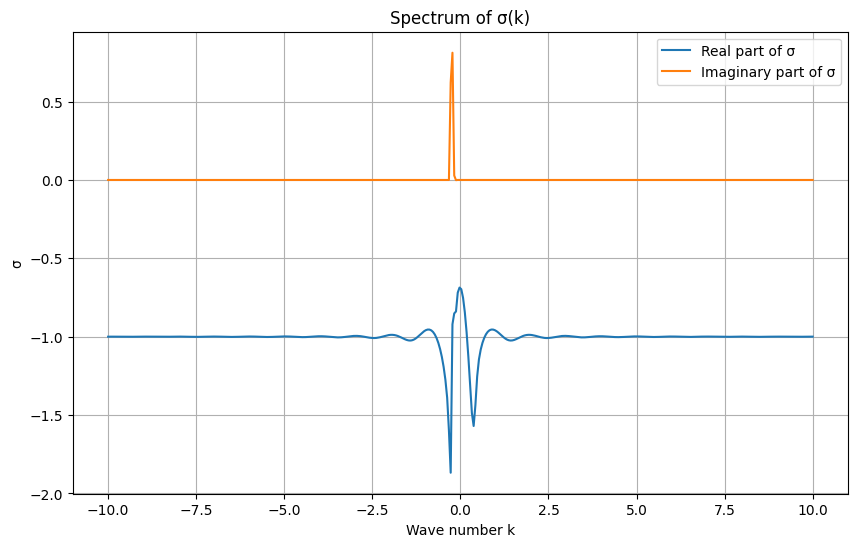

In [13]:
import numpy as np
from scipy.special import lambertw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

sampling_rate = 1000  # Hz (adjust if necessary)
start_time, end_time = 805.571, 921.515  # Data without stimulation occurring
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
EEG_data = EEG_data[start_index:end_index, :]

# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

# Define parameters (example values, please replace with your actual parameters)
epsilon = 1  # Delay factor (1/v where v is the velocity of propagation)
r = 2        # Parameter from the kernel function φ(x,r)



# Define a range of wave numbers k to analyze
k_values = np.linspace(-10, 10, 400)  # Replace with the appropriate range for your analysis

# Function to compute the Fourier transform of the kernel function, H(k, σ)
def H_tilde(k, sigma):
    Q1 = 4 * (np.pi * k) ** 2 - r ** 2 + epsilon ** 2 * sigma ** 2
    Q2 = 4 * (np.pi * k) ** 2 + r ** 2 - epsilon ** 2 * sigma ** 2
    return np.exp(-epsilon * sigma) * np.exp(-r * r) * (
        epsilon * sigma * np.exp(epsilon * sigma) * Q1 + r * np.exp(r) * (
            Q2 * np.cos(2 * np.pi * k) + 4 * epsilon * np.pi * k * sigma * np.sin(2 * np.pi * k)
        )
    ) / ((4 * (np.pi * k) ** 2 + r ** 2) ** 2 + 2 * epsilon ** 2 * (4 * (np.pi * k) ** 2 - r ** 2) * sigma ** 2 + epsilon ** 4 * sigma ** 4)

# Initialize array to hold the computed σ values for each k
sigma_values = np.zeros_like(k_values, dtype=np.complex128)

# Compute the spectrum σ(k) for each k
for i, k in enumerate(k_values):
    # Define the right-hand side of Eq. (20)
    R = H_tilde(k, sigma_values[i-1] if i > 0 else 0) * epsilon * np.exp(epsilon)
    
    # Solve for σ using the Lambert W function
    sigma_values[i] = lambertw(R) / epsilon - 1

# Plotting the spectrum (requires matplotlib, uncomment the following lines if you have matplotlib installed)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(k_values, sigma_values.real, label='Real part of σ')
plt.plot(k_values, sigma_values.imag, label='Imaginary part of σ')
plt.xlabel('Wave number k')
plt.ylabel('σ')
plt.title('Spectrum of σ(k)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
compare to fig1

In [15]:
import numpy as np
import os
from scipy.special import lambertw
import matplotlib.pyplot as plt

# Define directories
base_dir = '/mnt/data'  # Updated to the current accessible directory
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')  # Use the filename you uploaded

# Load EEG data
EEG_data = np.load(EEG_data_path, allow_pickle=True)

sampling_rate = 1000  # Hz
start_time, end_time = 805.571, 921.515  # Data without stimulation
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
EEG_data = EEG_data[start_index:end_index, :]

# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

# Parameters for the Amari neural field equation
epsilon = 1  # Delay factor (1/v where v is the velocity of propagation)
r = 2        # Parameter from the kernel function φ(x,r)
k_values = np.linspace(-0.25, 0, 400)  # k range from the figure

def calculate_spectrum(r, epsilon, k, branch):
    """
    Calculate the spectrum for a given r, epsilon, and k using the specified branch of the Lambert W function.
    """
    term_exp = epsilon * np.exp(epsilon) * (1 + np.exp(-2 * r)) * r
    term_cos_sin = (r + epsilon * k) * np.cos(2 * np.pi * k) - 2 * np.pi * k * np.sin(2 * np.pi * k)
    term_denominator = 4 * (np.pi * k)**2 + (r + epsilon * k)**2
    R = term_exp * term_cos_sin / term_denominator
    sigma = lambertw(R, k=branch) / epsilon - 1
    return sigma.real

# Plot spectrum for branches 1 and -1, which correspond to λ = 1 (pink) and λ = -1 (green)
plt.figure(figsize=(12, 8))
for k in k_values:
    sigma_plus = calculate_spectrum(r, epsilon, k, 1)  # Branch corresponding to λ = 1
    sigma_minus = calculate_spectrum(r, epsilon, k, -1)  # Branch corresponding to λ = -1
    plt.plot(k, sigma_plus, 'm.', markersize=2)  # Pink dot
    plt.plot(k, sigma_minus, 'g.', markersize=2)  # Green dot

plt.xlabel('Wave number k')
plt.ylabel('Re(σ)')
plt.title('Spectrum of the Amari Neural Field Equation')
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/eeg_data_with_channels.npy'

In [ ]:
implement eq 29
superposition of branches as in fig3

find what in fig4 and fig6

In [11]:
import numpy as np
import numpy as np
from scipy.optimize import fsolve

# Define the kernel function φ and the firing rate function F
def phi(x):
    # Placeholder for the actual function, e.g., Gaussian kernel
    return np.exp(-x**2)

def F(u):
    # Placeholder for the firing rate function
    return 1 / (1 + np.exp(-u))

# Define constants and setup grid
v = 1.0        # Propagation velocity
epsilon = 1/v  # Delay factor
t_max = 10     # Total time for simulation
x_max = 10     # Spatial extent
dx = 0.1       # Spatial resolution
dt = 0.1       # Time resolution
Nx = int(x_max / dx)  # Number of spatial points
Nt = int(t_max / dt)  # Number of time points

# Initialize the solution array with initial condition
u = np.zeros((Nx, Nt))

# Assume u[:, 0] is filled with initial conditions for t = 0

# Time integration using Euler's method
for t in range(1, Nt):
    for x in range(Nx):
        # Discretize space for the integral
        integral_sum = 0
        for y in range(Nx):
            # Calculate the delayed time index
            delayed_time_index = int(t - epsilon * np.abs(x*dx - y*dx) / dt)
            delayed_time_index = max(delayed_time_index, 0)
            
            # Add the contribution of the integral at this point
            integral_sum += phi((x-y)*dx) * F(u[y, delayed_time_index]) * dx
        
        # Update the value of u at this point using the Amari equation
        u[x, t] = dt * integral_sum + u[x, t-1]  # This assumes u_t + u = integral, modify accordingly

# u now contains the solution to the Amari equation over the grid



# Assume F'(u0) is known and is constant
F_prime_u0 = 1  # Placeholder value

# Define the function H_hat(k, sigma), which would involve the Fourier transform
# of the kernel function and possibly other terms specific to your problem.
def H_hat(k, sigma):
    # Placeholder for the actual function
    # This needs to be defined based on the specific kernel used in the Amari equation
    # For instance, if H_hat is a Fourier transform of an exponential decay, it might look like:
    # return np.exp(-sigma) * np.fft.fft(np.exp(-np.abs(k)))
    return np.exp(-sigma)  # Example placeholder

# Dispersion relation function to find zeros
def dispersion_relation(sigma, k):
    return sigma + 1 - F_prime_u0 * H_hat(k, sigma)

# Define the range of k values you are interested in
k_values = np.linspace(-10, 10, 200)  # Example range

# Store the computed sigma values for each k
sigma_solutions = []

# Solve the dispersion relation for each k
for k in k_values:
    # Guess for the initial value of sigma
    sigma_guess = 0.0
    # Solve for sigma using the fsolve function from scipy.optimize
    sigma_solution, = fsolve(dispersion_relation, sigma_guess, args=(k,))
    sigma_solutions.append(sigma_solution)

# sigma_solutions now contains the solutions to the dispersion relation for each k


In [ ]:
import numpy as np
from scipy.special import lambertw
import matplotlib.pyplot as plt

# Parameters based on the description
epsilon = 1  # Can be changed to 20 for the second plot
r = 200      # Can be changed to 2 for the second plot
k_values = np.linspace(-0.25, 0, 400)  # Adjust the range based on your figure needs

def calculate_sigma_at_zero(r, epsilon, branch):
    """
    Calculate the sigma for k=0 using the specific branch of the Lambert function.
    """
    numerator = epsilon * np.exp(epsilon) * (1 + np.exp(-2 * r)) * r
    denominator = r + epsilon
    return (lambertw(numerator / denominator, k=branch) / epsilon) - 1

def calculate_spectrum(k_values, branch):
    """
    Calculate the spectrum for a range of k values and a specific branch.
    """
    sigma_values = []
    sigma_previous = calculate_sigma_at_zero(r, epsilon, branch)

    for k in k_values:
        # Define the function to find the root
        def f(sigma):
            return epsilon * np.exp(epsilon * sigma) * (1 + np.exp(-2 * r)) * r / (r + epsilon * sigma) - np.exp(sigma)

        # Use the previous value as the initial guess
        sigma_solution = fsolve(f, sigma_previous.real)[0]
        sigma_previous = sigma_solution
        sigma_values.append(sigma_solution)

    return sigma_values

# Calculate and plot the spectra for several branches
branches = [-3, -2, -1, 0, 1, 2, 3]
plt.figure(figsize=(12, 8))

for b in branches:
    sigma_values = calculate_spectrum(k_values, b)
    plt.plot(k_values, sigma_values, label=f'Branch {b}')

# Marking the starting point for each branch
for b in branches:
    sigma_zero = calculate_sigma_at_zero(r, epsilon, b).real
    plt.plot(0, sigma_zero, 'ko')

plt.xlabel('k')
plt.ylabel('Re(σ)')
plt.title('Spectrum of the Amari Equation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from scipy.special import lambertw
import matplotlib.pyplot as plt

# Parameters based on the description
epsilon = 1  # Can be changed to 20 for the second plot
r = 200      # Can be changed to 2 for the second plot
k_values = np.linspace(-0.25, 0, 400)  # Adjust the range based on your figure needs

def calculate_sigma_at_zero(r, epsilon, branch):
    """
    Calculate the sigma for k=0 using the specific branch of the Lambert function.
    """
    numerator = epsilon * np.exp(epsilon) * (1 + np.exp(-2 * r)) * r
    denominator = r + epsilon
    return (lambertw(numerator / denominator, k=branch) / epsilon) - 1

def calculate_spectrum(k_values, branch):
    """
    Calculate the spectrum for a range of k values and a specific branch.
    """
    sigma_values = []
    sigma_previous = calculate_sigma_at_zero(r, epsilon, branch)

    for k in k_values:
        # Define the function to find the root
        def f(sigma):
            return epsilon * np.exp(epsilon * sigma) * (1 + np.exp(-2 * r)) * r / (r + epsilon * sigma) - np.exp(sigma)

        # Use the previous value as the initial guess
        sigma_solution = fsolve(f, sigma_previous.real)[0]
        sigma_previous = sigma_solution
        sigma_values.append(sigma_solution)

    return sigma_values

# Calculate and plot the spectra for several branches
branches = [-3, -2, -1, 0, 1, 2, 3]
plt.figure(figsize=(12, 8))

for b in branches:
    sigma_values = calculate_spectrum(k_values, b)
    plt.plot(k_values, sigma_values, label=f'Branch {b}')

# Marking the starting point for each branch
for b in branches:
    sigma_zero = calculate_sigma_at_zero(r, epsilon, b).real
    plt.plot(0, sigma_zero, 'ko')

plt.xlabel('k')
plt.ylabel('Re(σ)')
plt.title('Spectrum of the Amari Equation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import fsolve
from scipy.special import lambertw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
epsilon = 1  # example value, needs to be adjusted according to specific case
r = 20  # example value, adjust this as needed

# Define the function R(k,r,σ) which is the right-hand side of Eq. (20)
def R(k, r, sigma):
    # This is an example function representing R, the actual definition of R should come from the right-hand side of Eq. (20)
    # The example below is a placeholder and needs to be replaced with the actual expression
    return np.exp(epsilon * sigma) * np.cos(2 * np.pi * k)

# Define the dispersion relation function according to Eq. (21)
def dispersion_relation(k, r, branch):
    # Calculate the right-hand side of Eq. (21)
    rhs = R(k, r, branch)
    # Compute the Lambert W function for the given branch
    lambert_term = lambertw(rhs, k=branch)
    # Calculate the spectral value sigma using Eq. (21)
    sigma = (1/epsilon) * lambert_term - 1
    return sigma.real

# Range of k values to compute the spectrum over
k_values = np.linspace(-3, 3, 400)  # adjust range and density as needed

# Plotting the spectrum for each branch
branches = [-3, -2, -1, 0, 1, 2, 3]  # example branches, can include more
spectrum_values = {}

# Compute the spectrum for each branch and store results
for branch in branches:
    sigma_values = np.array([dispersion_relation(k, r, branch) for k in k_values])
    spectrum_values[branch] = sigma_values

# Plot the spectrum for all branches
plt.figure(figsize=(10, 6))
for branch, sigma_values in spectrum_values.items():
    plt.plot(k_values, sigma_values, label=f'Branch {branch}')
plt.xlabel('Wave number k')
plt.ylabel('Spectral value σ')
plt.title('Spectrum of the Amari Equation')
plt.legend()
plt.grid(True)
plt.show()

# For response surface visualization like Fig. 8, assuming we have the response surface data
# Here we are generating a mock data set as an example

# Generate k and omega values
k = np.linspace(-2.5, 2.5, 100)
omega = np.linspace(-1.5, 1.5, 100)
K, Omega = np.meshgrid(k, omega)

# Generate response surface data (this is just an example, you would replace this with your actual response data)
Response = np.cos(K) * np.exp(-Omega**2)

# Plot the response surface
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K, Omega, Response, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('Wave number k')
ax.set_ylabel('Frequency ω')
ax.set_zlabel('Response')
ax.set_title('Response Surface of the Amari Neural Field Equation')
plt.show()


### Welch's PSD and PSD from FFT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

# Define the sampling frequency and other parameters
fs = 1000

# Define the timepoints for the start and stop of each stimulation
# Extracted from your provided times - adjust indices as per your data structure
stim_times = [
    (654746.0, 770515.0),
    (805571.0, 921515.0),
    (2156695.0, 2272756.0),
    (2307798.0, 3019822.0)
]

# Initialize a dictionary to store EEG segments post-stimulation
post_stim_segments = {}

for i, (stim_stop, stim_start) in enumerate(stim_times):
    start_index, end_index = int(stim_stop * (fs/1000)), int(stim_start * (fs/1000))
    # Assuming EEG_data is a NumPy array with shape (timepoints, channels)
    eeg_segment = EEG_data[start_index:end_index, :]
    post_stim_segments[f'segment_{i}'] = eeg_segment
# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

# Initialize dictionaries to store PSD values for each channel
welch_psd_data = {}
fft_psd_data = {}

# Loop through each EEG channel to calculate PSD using both Welch's method and FFT
for i, channel in enumerate(eeg_channels):
    # Select EEG data from the current channel
    eeg_data = EEG_data[:, i]
    
    # Use Welch's method to estimate the power spectral density
    welch_frequencies, welch_psd = signal.welch(eeg_data, fs, nperseg=1024)
    welch_psd_data[channel] = welch_psd
    
    # Compute the FFT and then calculate the PSD
    fft_result = np.fft.fft(eeg_data)
    fft_psd = np.abs(fft_result) ** 2 / len(eeg_data)
    fft_frequencies = np.fft.fftfreq(len(eeg_data), d=1/fs)
    fft_psd_data[channel] = fft_psd

# Plotting the Welch PSD data
plt.figure(figsize=(15, 24))
for i, channel in enumerate(eeg_channels):
    plt.subplot(len(eeg_channels), 1, i+1)
    plt.semilogy(welch_frequencies, welch_psd_data[channel])
    plt.title(f'Welch PSD - EEG Channel {channel}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting the FFT PSD data
plt.figure(figsize=(15, 24))
for i, channel in enumerate(eeg_channels):
    # Plot only positive frequencies
    positive_freqs = fft_frequencies > 0
    plt.subplot(len(eeg_channels), 1, i+1)
    plt.semilogy(fft_frequencies[positive_freqs], fft_psd_data[channel][positive_freqs])
    plt.title(f'FFT PSD - EEG Channel {channel}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2]')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Save the Welch PSD data as a numpy array
welch_save_path = '/path/to/welch_psd_data.npy'
np.save(welch_save_path, welch_psd_data)

# Save the FFT PSD data for all channels as a numpy file
fft_save_path = '/path/to/fft_psd_data.npy'
np.save(fft_save_path, fft_psd_data)

### Harmonics Detection

In [ ]:
def find_harmonics(frequencies, psd, fundamental_freq, harmonics_count=5):
    """
    Find harmonics of a fundamental frequency within the PSD data.

    :param frequencies: Array of frequencies corresponding to PSD values
    :param psd: PSD values for a specific channel
    :param fundamental_freq: The fundamental frequency to find harmonics of
    :param harmonics_count: Number of harmonics to identify
    :return: List of identified harmonics and their powers
    """
    harmonics = []
    tolerance = 0.5  # Frequency tolerance in Hz, adjust based on your resolution
    for n in range(1, harmonics_count + 1):
        harmonic_freq = fundamental_freq * n
        # Find the closest frequency in the array to the expected harmonic frequency
        idx = (np.abs(frequencies - harmonic_freq)).argmin()
        if np.abs(frequencies[idx] - harmonic_freq) <= tolerance:
            harmonics.append((frequencies[idx], psd[idx]))
    return harmonics

# Example analysis for a single channel, adjust as needed for your analysis
channel = 'Fp1'
fundamental_freq = 10  # Example fundamental frequency in Hz, adjust based on your findings

harmonics = find_harmonics(frequencies, psd_data[channel], fundamental_freq)

# Print identified harmonics and their powers
for freq, power in harmonics:
    print(f"Harmonic at {freq} Hz with power {power}")

# Visualizing the PSD with highlighted harmonics
plt.semilogy(frequencies, psd_data[channel], label='PSD')
for freq, power in harmonics:
    plt.plot(freq, power, 'ro')  # Mark harmonics with red circles
plt.title(f'PSD with Harmonics for Channel {channel}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
see about using lyapunovs and phase space components  instead with use within harmonics analysis

see about combining all 

In [ ]:
oscillatory divergence and convergence harmonics? Multiscale Entropy ?

In [ ]:
frequencies ?=

In [ ]:
def find_lyapunov_harmonics(lyapunov_exponents, base_value, harmonics_count=5):
    """
    Find 'harmonic' patterns within Lyapunov exponent data.

    :param lyapunov_exponents: List of Lyapunov exponents for a specific channel
    :param base_value: The base measure to find 'harmonics' of
    :param harmonics_count: Number of 'harmonics' to identify
    :return: List of 'harmonics' and their corresponding exponents
    """
    harmonics = []
    tolerance = 0.05  # Adjust based on your system, may represent a percentage tolerance
    
    # Assuming that the 'harmonic' is defined as a multiple of the base value within the Lyapunov exponents
    for n in range(1, harmonics_count + 1):
        harmonic_value = base_value * n
        # Find the exponent closest to the expected 'harmonic' value
        for exp in lyapunov_exponents:
            if abs(exp - harmonic_value) / harmonic_value <= tolerance:
                harmonics.append(exp)
                break  # Assuming only one match per harmonic level
    
    return harmonics

# Define the base measure for 'harmonic' detection; this is conceptual
base_measure = -0.05  # Placeholder for a base measure of system stability

# Assuming 'lyapunov_exponents' is a list of Lyapunov exponents for a channel
harmonics = find_lyapunov_harmonics(lyapunov_exponents, base_measure)

# Print identified 'harmonics'
for harmonic in harmonics:
    print(f"'Harmonic' Lyapunov exponent: {harmonic}")


Resonance Frequency Analysis using CFC , dynamic wavelet analysis and adaptive STFT

Compare PSD before and after stim

multipartite concurrence

quantum discord

### 

Dynamic Time Warping

Cross Recurrence Plot

Nonlinear Correlation Coefficient

Symbolic Dynamics

Multivariate Multiscale Dispersion Lempel-Ziv Complexity (mvMDLZC)

Symbolic Transfer Entropy

Conditional Mutual Information

Information Transfer and Connectivity

Coherence

Phase Lag Index

Granger Causality

Partial Directed Coherence

Directed Transfer Function

Phase Transfer Entropy

Dynamic Causal Modeling

Granger Causality in Frequency Domain

Cross-Frequency Coupling

Synchronization Likelihood

Adaptive Filtering for Information Flow

Effective Connectivity via Bayesian Networks

Time-Varying Graph Theoretical Analysis

Cross-Frequency Phase-Amplitude Coupling

Machine Learning and Data Dimensionality Reduction

t-SNE

PCA (Principal Component Analysis)

Manifold Learning

Topology-Informed Machine Learning

Geometric Learning Algorithms



Topological Data Analysis

Persistent Homology

Topological Regularization

Topological Summaries

Probabilistic Inference on Manifolds

Modeling Neural Manifolds

Curvature Analysis



Electromagnetic Field and Neural Modeling

Nonlinear Energy Operators

Finite Element Method

Multipole Expansion

Discrete Dipole Approximation

Minimum Norm Estimates

Beamforming

Quantum Mechanics Inspired

Modified Quantum Stochastic Processes

Modified Quantum Field Theory




Complex Systems and Network Analysis

Integrated Information Theory

Network Motifs

Graph Spectral Analysis



Signal Processing Techniques

Hilbert-Huang Transform

Wavelet Coherence



Cognitive and Computational Neuroscience

Predictive Coding

Neurosymbolic Computing



Additional Concepts

Free Energy Minimization

Divergence, Log-Evidence

Negative Free Energy, Evidence Bound

Geodesic Paths

Evolution Rate

Renormalization Group Analysis

Information Flow Networks

State-Space Reconstruction for Connectivity